# 1. Чтение данных, общая информация о данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState


from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder
)

from sklearn.metrics import (
    f1_score, 
    roc_curve, 
    roc_auc_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split, 
    cross_val_score
)
from sklearn.utils import shuffle #?
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)

Объявляет переменные и функции:

In [2]:
# константы
RANDOM_STATE = 12345

In [3]:
# функция для восстановления значений: 
# получает срез ДФ, "склеивает" значения полей 'a' и 'b' и разносит их заново
# возвращает тот же срез с изменнными данными
def restore (df_calc, a, b):
    
    # для нулевых значений во втором столбце
    if df_calc[b].sum() == 0:
        df_calc = df_calc.assign(tmp = lambda x: (x[a]))
        df_calc[b] = df_calc.apply(lambda x: int((x['tmp']%10*10)), axis=1)
        df_calc[a] = df_calc.apply(lambda x: int((x['tmp']/10)), axis=1)
        
    else:
        #создаёт дополнительный временный столбец, производит вычисления через него и удаляет
        df_calc = df_calc.assign(tmp = lambda x: (x[a].astype(str)+x[b].astype(str)).astype(int))
        df_calc[a] = df_calc.apply(lambda x: int((x['tmp'] - x['tmp']%100)/100), axis=1)
        df_calc[b] = df_calc.apply(lambda x: x['tmp']%100, axis=1)
    
    df_calc.drop(columns='tmp', inplace=True)
    return df_calc

In [4]:
# чтение данных и создание ДФ:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


In [7]:
df_train.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [8]:
df_test.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1
5,17,16712,1,160,68.0,120,80,1,1,0,0,0
6,19,15873,2,170,68.0,120,80,1,1,0,0,0
7,20,20424,1,164,60.0,120,80,1,1,0,0,0
8,22,20262,1,170,68.0,110,70,1,1,0,0,1
9,26,21737,1,162,88.0,180,100,2,2,0,1,1


In [9]:
df_test.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
dtype: object

In [10]:
df_train.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

Проверяет пропуски в данных:

In [11]:
df_train.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [12]:
df_test.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64

<u>Выводы</u>:\
имеем два достаточно больших массива данных без пропусков и, что важно, без категориальных текстовых данных.\
С точки зрения пропусков и типов данных массивы пока не тербуют обработки.

# 2. Предобработка данных

## 2.1. Уникальность id

In [13]:
# ищет дубликаты в столбцах 'id'
df_train.duplicated('id').sum(), df_test.duplicated('id').sum()

(0, 0)

In [14]:
# проверяет совпадение 'id' обучающего и тестового ДФ:
train_id = df_train['id']
test_id = df_test['id']
train_id.isin(test_id).sum()

0

Вывод: `id` уникальны -- не повторяются ни внутри ДФ, ни в другом ДФ. 

## 2.2 Категориальные признаки

#### Гендер

Получаем пол (`gender`) по росту (`height`):

In [15]:
df_train[df_train['gender'] == 1]['height'].mean()

161.35561168460356

In [16]:
df_train[df_train['gender'] == 2]['height'].mean()

169.94789538210054

<u>Итого</u>:\
`1` - женщины - средний рост 161.3\
`2` - мужчины - средний рост 169.9

Логично привести этот признак к "стандартному" представлению категориального признака "0-1":

In [17]:
df_train['gender'] = df_train['gender'].map({1: 0, 2: 1})
df_test['gender'] = df_test['gender'].map({1: 0, 2: 1})

In [18]:
df_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,1,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,0,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,0,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,1,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,0,156,56.0,100,60,1,1,0,0,0,0


<u>Теперь</u>:\
`0` - женщины\
`1` - мужчины

#### Холестерол 

Выполним аналогичные действия с холестеролом и глюкозой:

In [19]:
df_train['cholesterol'] = df_train['cholesterol'].map({1:0, 2:1, 3:2})
df_test['cholesterol'] = df_test['cholesterol'].map({1:0, 2:1, 3:2})

#### Глюкоза 

In [20]:
df_train['gluc'] = df_train['gluc'].map({1:0, 2:1, 3:2})
df_test['gluc'] = df_test['gluc'].map({1:0, 2:1, 3:2})

Возможно, в этих действиях не было никакого смысла: модель так или иначе "подхватила" бы данные независимо от того, с какой цифры они начинаются - с "1" или с "0".

## 2.3 Логические аномалии

In [21]:
df_train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,0.349571,0.476838,0.0,0.00,0.0,1.00,1.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,0.366871,0.680250,0.0,0.00,0.0,1.00,2.0
gluc,70000.0,0.226457,0.572270,0.0,0.00,0.0,0.00,2.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [22]:
df_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,50062.686900,28906.167148,5.0,24983.25,49995.5,75232.25,99997.0
age,30000.0,19455.528400,2477.840922,8865.0,17658.00,19694.0,21320.00,23705.0
gender,30000.0,0.353733,0.478136,0.0,0.00,0.0,1.00,1.0
height,30000.0,164.322267,8.213740,50.0,159.00,165.0,170.00,198.0
weight,30000.0,74.120615,14.341540,10.0,65.00,72.0,82.00,183.0
ap_hi,30000.0,130.271300,212.501152,-130.0,120.00,120.0,140.00,16020.0
ap_lo,30000.0,95.689000,163.852598,-90.0,80.00,80.0,90.00,9100.0
cholesterol,30000.0,0.368033,0.679166,0.0,0.00,0.0,1.00,2.0
gluc,30000.0,0.222700,0.566494,0.0,0.00,0.0,0.00,2.0
smoke,30000.0,0.088600,0.284170,0.0,0.00,0.0,0.00,1.0


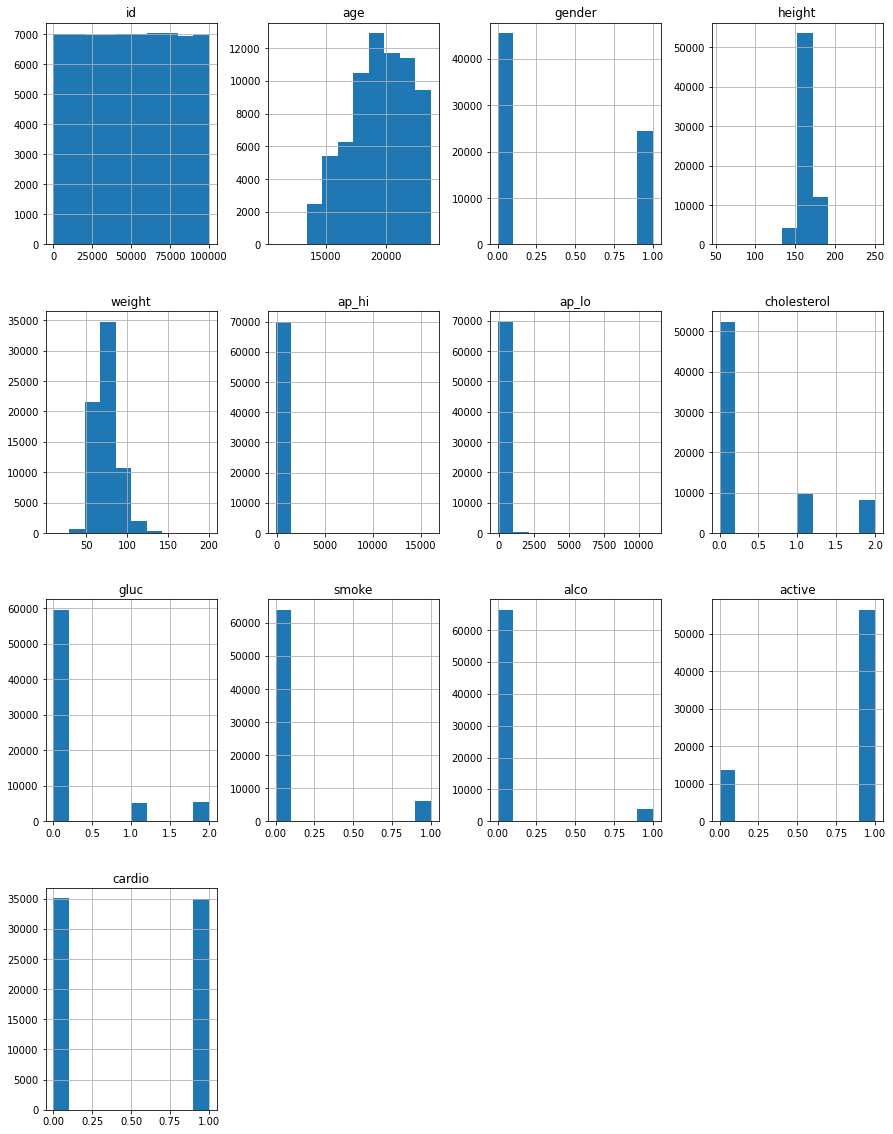

In [23]:
# строит гистограммы для всех столбцов
df_train.hist(figsize=(15, 20))
plt.show()

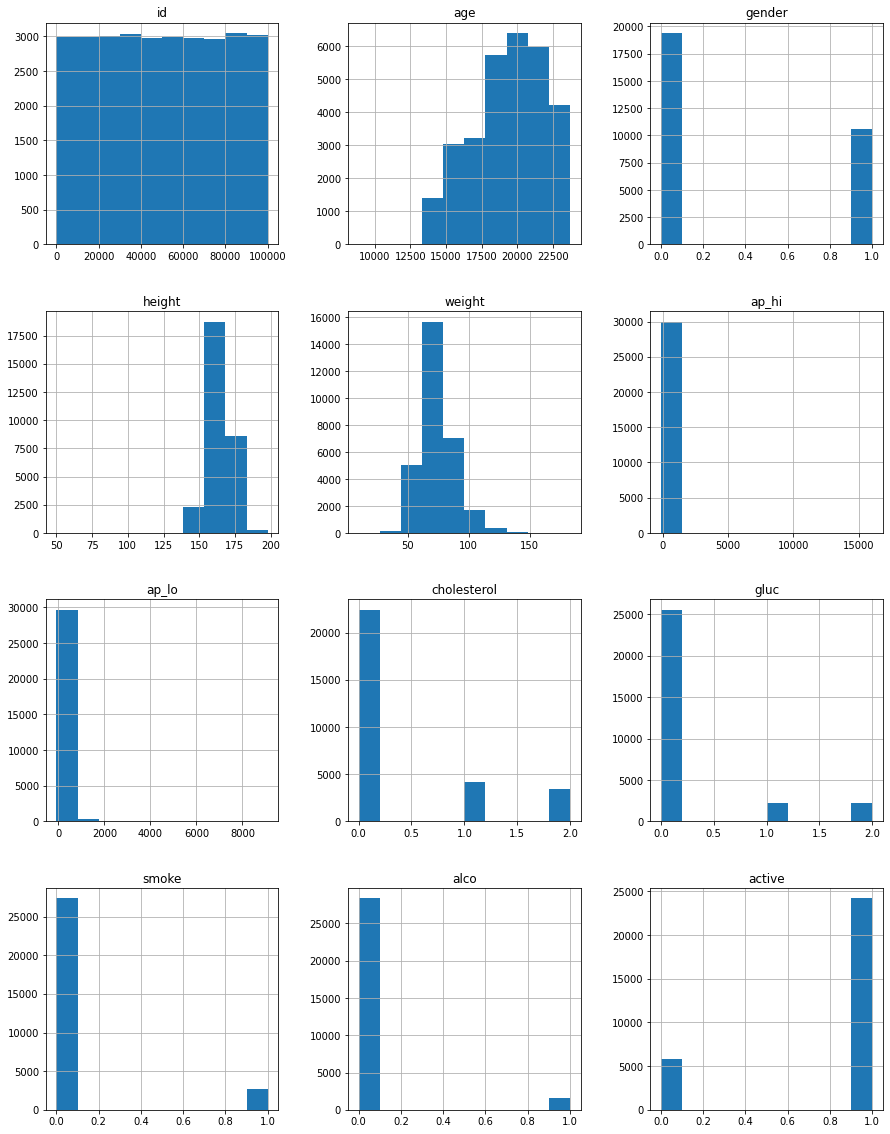

In [24]:
# строит гистограммы для всех столбцов
df_test.hist(figsize=(15, 20))
plt.show()

<u>Значения равные нулю</u>:

In [25]:
df_train[df_train['ap_lo'] == 0]['id'].count()

21

In [26]:
df_train[df_train['ap_hi'] == 0]['id'].count()

0

In [27]:
df_test[df_test['ap_lo'] == 0]['id'].count()

7

In [28]:
df_test[df_test['ap_hi'] == 0]['id'].count()

0

Построим матрицу корреляции, чтобы получить примерное представление о взаимозависимости параметров:

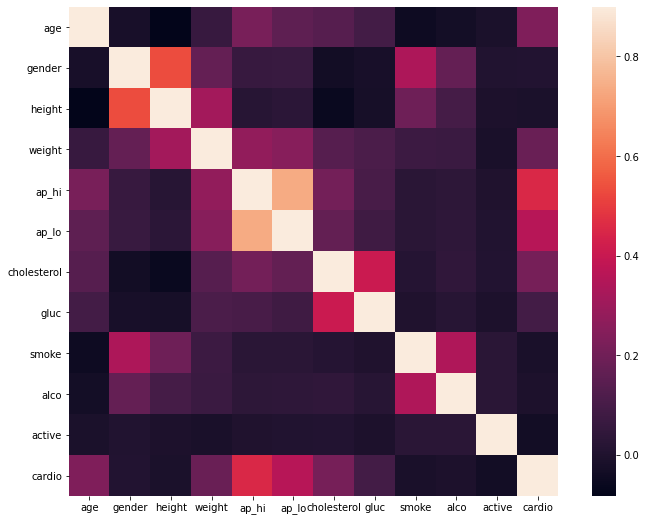

In [29]:
corrmat = df_train.drop(['id'], axis=1).corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True)
plt.show()

Что видим сразу:
- 4 параметра, в которых есть потенциально аномальные данные:

1) `ap_hi` ("верхнее" давление)\
2) `ap_lo` ("нижнее" давление)\    
    - отрицательные значения\
    - нулевые (!) значения (только у `ap_lo` !)\
    - подозрительные max и min значения
 
3) `height` (рост)\
4) `weight` (вес)\
    - подозрительные max и min значения

Даже на НЕ ОБРАБОТАННЫХ данных:
- наибольшая корреляция ЦЗ - с `ap_hi`, затем `ap_lo`, возраст (`age`), вес, холестерол, глюкоза.
- наибольшая корреляция `ap_hi` - с `ap_lo`, затем - `weight` (вес) (!)
- наибольшая корреляция веса - с ростом (`height`), что логично
- курение, алкоголь, активность, пол и даже рост (!) - не коррелируют с ЦЗ! (во всяком случае, не коррелируют НАПРЯМУЮ).

### Давление `ap_hi`: верхнее (систолическое) давление

#### Минимальные значения:

**Тренировочные данные**

<u>Нулевые значения</u>

In [30]:
df_train[df_train['ap_hi'] == 0]['ap_hi'].count()

0

<u>Отрицательные значения</u>

In [31]:
df_train[df_train['ap_hi'] < 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
4607,6525,15281,0,165,78.0,-100,80,1,0,0,0,1,0
16021,22881,22108,1,161,90.0,-115,70,0,0,0,0,1,0
20536,29313,15581,0,153,54.0,-100,70,0,0,0,0,1,0
23988,34295,18301,0,162,74.0,-140,90,0,0,0,0,1,1
25240,36025,14711,1,168,50.0,-120,80,1,0,0,0,0,1
35040,50055,23325,1,168,59.0,-150,80,0,0,0,0,1,1
46627,66571,23646,1,160,59.0,-120,80,0,0,0,0,0,0


In [32]:
df_train.loc[df_train['ap_hi'] < 0, 'ap_hi'].count()

7

In [33]:
df_train.loc[df_train['ap_hi'] < 0, 'ap_hi'] *= -1
df_train.loc[df_train['ap_hi'] < 0, 'ap_hi'].count()

0

<u>Значения меньше порогового N</u>

Подбором нашли порог, ниже которого возникает "провал" в данных - это "60":

In [34]:
df_train[df_train['ap_hi'] < 65]['ap_hi'].max()

60

In [35]:
df_train[df_train['ap_hi'] < 60]['ap_hi'].max()

24

Поэтому будем считать, что все, что ниже 60 - фейковые данные.

In [36]:
df_train[df_train['ap_hi'] < 60]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
567,815,21281,0,168,78.0,14,90,1,0,0,0,1,1
927,1294,21867,1,175,70.0,14,90,2,0,0,0,1,1
979,1360,18225,0,172,65.0,11,80,0,2,0,0,1,0
1600,2260,19201,0,165,66.0,12,80,0,0,0,0,1,0
1627,2301,22591,0,165,71.0,14,80,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68630,98039,21217,0,160,59.0,12,80,0,0,0,0,1,0
68742,98213,18755,0,158,74.0,14,90,0,0,0,0,1,1
68998,98568,19107,0,154,77.0,14,90,0,0,0,0,1,0
69137,98743,15442,1,176,65.0,12,80,0,0,0,0,1,0


Выделим подгруппу со значениями меньше 10:

In [37]:
df_train[df_train['ap_hi'] < 10]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
5382,7657,21240,0,162,69.0,7,80,0,0,0,0,1,0
8757,12494,16905,1,163,63.0,1,2088,0,0,1,0,1,0
42334,60477,18716,0,171,80.0,1,1088,0,0,0,0,1,1


Обращаем внимание на его "пару" - `ap_lo`:

In [38]:
df_train[(df_train['ap_hi'] < 60) & (df_train['ap_lo'] > 190)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
8757,12494,16905,1,163,63.0,1,2088,0,0,1,0,1,0
42334,60477,18716,0,171,80.0,1,1088,0,0,0,0,1,1
64409,91933,21157,1,173,94.0,13,585,1,0,0,0,1,1


Будем считать это ошибочным "переносом" данных из одного поля в другое и импользуем функцию для замены ("восстановления") таких данных (объявлена в начале):

Отправляет в функцию срез данных и получает срез с исправленными значениями:

In [39]:
df_cut = restore(df_train[(df_train['ap_hi'] < 60) & (df_train['ap_lo'] > 190)],'ap_hi','ap_lo')
df_cut

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
8757,12494,16905,1,163,63.0,120,88.0,0,0,1,0,1,0
42334,60477,18716,0,171,80.0,110,88.0,0,0,0,0,1,1
64409,91933,21157,1,173,94.0,135,85.0,1,0,0,0,1,1


Заменяет строки ДФ строками среза данных по индексам и проверяет:

In [40]:
df_train.loc[df_cut.index] = df_cut
df_train.loc[[64409]]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
64409,91933,21157,1,173,94.0,135,85.0,1,0,0,0,1,1


Остальные значения меньше 60 просто умножаем на 10 и проверяем:

In [41]:
df_train.loc[df_train['ap_hi'] < 60, 'ap_hi'] *= 10
df_train[(df_train['ap_hi'] < 60)]['id'].count()

0

Посмотрим на данные больше 60 и меньше 90:

In [42]:
df_train[(df_train['ap_hi'] > 60)&(df_train['ap_hi'] < 90)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
209,288,18169,1,172,62.0,80,70.0,0,0,0,0,1,0
383,543,19517,0,147,41.0,80,50.0,0,0,0,0,1,0
636,913,20457,1,169,68.0,70,110.0,0,0,0,0,1,0
2990,4214,21957,1,182,90.0,80,140.0,2,2,0,0,1,1
3447,4880,19992,1,180,80.0,80,125.0,2,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67470,96339,21193,1,172,57.0,80,120.0,0,0,1,0,1,1
68021,97151,21701,0,154,64.0,85,66.0,0,0,0,1,1,0
68067,97210,18421,0,152,65.0,80,120.0,0,0,0,0,1,0
68665,98104,16853,1,164,72.0,80,60.0,0,0,1,0,0,0


Видим, что часть данных нужно привести в соответствие с условием `ap_hi > ap_lo`.\
Однако для этого данные ещё недостаточно обработаны:\
у нас уже нет минимальных значений `ap_hi`, однако максимальные `ap_lo` еще НЕ ОБРАБОТАНЫ!\
Нужно будет вернуться к этой процедуре - замена по условию ПЛЮС анализ интервала от 60 до 90 - после обработки `ap_lo`.

**Тестовые данные**

Повторяем процедуру для тестовых данных:

<u>Нулевые значения</u>

In [43]:
df_test[df_test['ap_hi'] == 0]['ap_hi'].count()

0

<u>Отрицательные значения</u>

In [44]:
df_test[df_test['ap_hi'] < 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
21811,72958,22597,1,166,68.0,-130,80,0,0,0,0,1
22231,74371,15841,1,158,52.0,-12,80,1,0,0,0,1


In [45]:
df_test.loc[df_test['ap_hi'] < 0, 'ap_hi'] *= -1
df_test.loc[df_test['ap_hi'] < 0, 'ap_hi'].count()

0

<u>Значения меньше порогового N</u>

Просто повторяем в точности ту же процедуру, что на тренировочных данных:

In [46]:
df_test[df_test['ap_hi'] < 60]['ap_hi'].max()

20

In [47]:
df_test[(df_test['ap_hi'] < 60) & (df_test['ap_lo'] > 190)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
1929,6580,19079,0,176,92.0,1,1099,0,0,0,0,1
15510,51749,18419,0,169,62.0,1,2088,0,0,0,0,1
29333,97818,14420,0,163,83.0,11,570,0,0,0,0,1


In [48]:
df_cut = restore(df_test[(df_test['ap_hi'] < 60) & (df_test['ap_lo'] > 190)],'ap_hi','ap_lo')
df_cut

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
1929,6580,19079,0,176,92.0,110,99.0,0,0,0,0,1
15510,51749,18419,0,169,62.0,120,88.0,0,0,0,0,1
29333,97818,14420,0,163,83.0,115,70.0,0,0,0,0,1


In [49]:
df_test.loc[df_cut.index] = df_cut
df_test.loc[[29333]]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
29333,97818,14420,0,163,83.0,115,70.0,0,0,0,0,1


In [50]:
df_test.loc[df_test['ap_hi'] < 60, 'ap_hi'] *= 10
df_test[(df_test['ap_hi'] < 60)]['id'].count()

1

Одно значение не обработалось до конца:

In [51]:
df_test[(df_test['ap_hi'] < 60)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
12852,42755,19136,0,158,61.0,10,30.0,0,0,0,0,1


Его проще обработать вручную:\
здесь была пара "1-30", поэтому будем считать, что реальный данные здесь "130 - 0"

In [52]:
df_test.loc[df_test['id'] == 42755, ['ap_hi','ap_lo']] = [130,0]
df_test[(df_test['ap_hi'] < 60)]['id'].count()

0

#### Максимальные значения

**Тренировочные данные**

<u>Значения БОЛЬШЕ порогового N</u>

Действуем аналогичным образом, но "в другую сторону" - в сторону увеличения значений данных.\
Находим пороговое значение - здесь это "190":

In [53]:
df_train[df_train['ap_hi'] > 230]['ap_hi'].min()

240

In [54]:
df_train[df_train['ap_hi'] > 240]['ap_hi'].min()

309

In [55]:
df_train.loc[df_train['ap_hi'] == 309]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
40330,57646,20322,0,162,50.0,309,0.0,0,0,0,0,1,0


In [56]:
df_train[df_train['ap_hi'] > 240]['ap_hi'].max()

16020

In [57]:
df_train.loc[df_train['ap_hi'] == 16020]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
40852,58374,17438,0,169,70.0,16020,80.0,0,0,0,0,0,1


In [58]:
df_train.loc[df_train['ap_hi'] > 240]['ap_hi'].count()

40

In [59]:
df_train.loc[df_train['ap_hi'] > 240]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1876,2654,15116,0,160,60.0,902,60.0,0,0,0,0,1,0
2014,2845,22712,1,167,59.0,906,0.0,0,0,0,0,1,0
4817,6822,14425,0,168,63.0,909,60.0,1,0,0,0,1,0
7763,11089,21032,0,175,80.0,11500,90.0,0,0,0,0,1,1
8915,12710,18870,0,164,75.0,1420,80.0,1,0,0,0,1,1
9557,13616,22659,0,155,87.0,701,110.0,0,0,0,0,1,1
13895,19827,15996,0,168,72.0,1500,80.0,0,0,0,0,1,1
17713,25314,22398,1,163,50.0,907,70.0,2,2,0,0,1,1
23867,34120,16131,0,161,92.0,906,0.0,1,0,0,0,1,1
25464,36339,15835,1,169,75.0,14020,80.0,1,0,0,0,1,1


Создадим срез с тем же услвоием и нулевыми значениями `ap_lo`:

In [60]:
df_train.loc[(df_train['ap_hi'] > 240) & (df_train['ap_lo'] == 0)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2014,2845,22712,1,167,59.0,906,0.0,0,0,0,0,1,0
23867,34120,16131,0,161,92.0,906,0.0,1,0,0,0,1,1
31783,45400,16070,0,170,64.0,907,0.0,0,0,0,0,1,0
40330,57646,20322,0,162,50.0,309,0.0,0,0,0,0,1,0
41505,59301,20970,0,154,41.0,806,0.0,0,0,0,0,1,0
42397,60565,17988,1,176,69.0,906,0.0,0,0,0,0,1,0
68663,98095,18190,0,156,41.0,906,0.0,0,0,0,0,1,0


Применм функцию:

In [61]:
df_cut = restore(df_train.loc[(df_train['ap_hi'] > 240) & (df_train['ap_lo'] == 0)],'ap_hi','ap_lo')
df_cut

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2014,2845,22712,1,167,59.0,90,60,0,0,0,0,1,0
23867,34120,16131,0,161,92.0,90,60,1,0,0,0,1,1
31783,45400,16070,0,170,64.0,90,70,0,0,0,0,1,0
40330,57646,20322,0,162,50.0,30,90,0,0,0,0,1,0
41505,59301,20970,0,154,41.0,80,60,0,0,0,0,1,0
42397,60565,17988,1,176,69.0,90,60,0,0,0,0,1,0
68663,98095,18190,0,156,41.0,90,60,0,0,0,0,1,0


In [62]:
df_train.loc[df_cut.index] = df_cut
df_train.loc[[68663]]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
68663,98095,18190,0,156,41.0,90,60.0,0,0,0,0,1,0


In [63]:
df_train.loc[(df_train['ap_hi'] > 240) & (df_train['ap_lo'] == 0)]['id'].count()

0

In [64]:
df_train.loc[df_train['ap_hi'] > 240]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1876,2654,15116,0,160,60.0,902,60.0,0,0,0,0,1,0
4817,6822,14425,0,168,63.0,909,60.0,1,0,0,0,1,0
7763,11089,21032,0,175,80.0,11500,90.0,0,0,0,0,1,1
8915,12710,18870,0,164,75.0,1420,80.0,1,0,0,0,1,1
9557,13616,22659,0,155,87.0,701,110.0,0,0,0,0,1,1
13895,19827,15996,0,168,72.0,1500,80.0,0,0,0,0,1,1
17713,25314,22398,1,163,50.0,907,70.0,2,2,0,0,1,1
25464,36339,15835,1,169,75.0,14020,80.0,1,0,0,0,1,1
25519,36414,21361,0,169,71.0,14020,80.0,2,2,0,0,1,1
25780,36793,18304,0,157,83.0,1400,80.0,0,0,0,0,1,1


Имеем диапазоны:\
`5 разрядов`: 16020\
`4 разряда`: 1300\
`3 разряда`: 401\
В последнем поддиапазон `< 900`, в котором нужно поменять местами две цифры.

In [65]:
df_train.loc[(df_train['ap_hi'] > 240) & (df_train['ap_hi'] < 900)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
9557,13616,22659,0,155,87.0,701,110.0,0,0,0,0,1,1
40831,58349,19806,0,162,67.0,401,80.0,0,2,0,0,1,1


Можно написать код, который будет переставлять "1" в начало, но быстрее и проще поменять вручную:

In [66]:
df_train.loc[df_train['id'] == 13616, ['ap_hi']] = 170
df_train.loc[df_train['id'] == 58349, ['ap_hi']] = 140

Остальные данные последовательно делим на 10:

In [67]:
df_train.loc[df_train['ap_hi'] > 240, 'ap_hi'] /= 10
df_train.loc[df_train['ap_hi'] > 240, 'ap_hi'].count()

9

Повторяет деление на 10, т.к. данные ещё остались:

In [68]:
df_train.loc[df_train['ap_hi'] > 240, 'ap_hi'] /= 10
df_train.loc[df_train['ap_hi'] > 240, 'ap_hi'].count()

0

Повторно проверяет на значения, ниже порогового:

In [69]:
df_train[(df_train['ap_hi'] < 60)]['id'].count()

1

In [70]:
df_train[(df_train['ap_hi'] < 60)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
40330,57646,20322,0,162,50.0,30.0,90.0,0,0,0,0,1,0


Здесь ориентируемся на нижнее давление и тоже меняем вручную:

In [71]:
df_train.loc[df_train['id'] == 57646, ['ap_hi']] = 130

In [72]:
df_train[(df_train['ap_hi'] < 60)]['id'].count()

0

**Тестовые данные**

<u>Значения БОЛЬШЕ порогового N</u>

In [73]:
df_test[df_test['ap_hi'] > 240]['ap_hi'].min()

400

In [74]:
df_test.loc[df_test['ap_hi'] > 240]['ap_hi'].count()

19

In [75]:
df_test.loc[df_test['ap_hi'] > 240]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
303,1079,22571,1,170,74.0,400,60.0,0,0,0,0,1
1685,5736,15180,0,147,53.0,907,70.0,0,0,0,0,1
5176,17266,20437,0,157,85.0,12008,80.0,0,0,0,0,1
6958,23199,18095,0,166,64.0,957,70.0,0,0,0,0,0
7463,24871,20609,0,168,56.0,906,60.0,1,0,0,0,1
7755,25868,18990,0,170,64.0,14020,90.0,0,0,0,0,1
8852,29568,21785,0,165,58.0,16020,70.0,0,0,0,0,1
9262,30877,15916,1,180,70.0,906,60.0,0,0,0,0,1
9399,31334,16519,0,151,56.0,14020,90.0,0,0,0,0,1
10566,35256,18489,0,160,86.0,1502,80.0,1,0,0,0,1


In [76]:
df_test.loc[(df_test['ap_hi'] > 240) & (df_test['ap_lo'] == 0)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
18857,62837,19912,1,170,79.0,509,0.0,0,0,0,0,1
29982,99929,21976,1,164,79.0,906,0.0,0,0,1,0,1


In [77]:
df_cut = restore(df_test.loc[(df_test['ap_hi'] > 240) & (df_test['ap_lo'] == 0)],'ap_hi','ap_lo')
df_cut

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
18857,62837,19912,1,170,79.0,50,90,0,0,0,0,1
29982,99929,21976,1,164,79.0,90,60,0,0,1,0,1


In [78]:
df_test.loc[df_cut.index] = df_cut
df_test.loc[[29982]]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
29982,99929,21976,1,164,79.0,90,60.0,0,0,1,0,1


In [79]:
df_test.loc[(df_test['ap_hi'] > 240) & (df_test['ap_lo'] == 0)]['id'].count()

0

In [80]:
df_test.loc[(df_test['ap_hi'] > 240) & (df_test['ap_hi'] < 900)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
303,1079,22571,1,170,74.0,400,60.0,0,0,0,0,1


In [81]:
df_test.loc[df_test['id'] == 1079, ['ap_hi']] = 140

Остальные данные последовательно делим на 10:

In [82]:
df_test.loc[df_test['ap_hi'] > 240, 'ap_hi'] /= 10
df_test.loc[df_test['ap_hi'] > 240, 'ap_hi'].count()

7

In [83]:
df_test.loc[df_test['ap_hi'] > 240, 'ap_hi'] /= 10
df_test.loc[df_test['ap_hi'] > 240, 'ap_hi'].count()

0

Повторно проверяет на минимальные значения:

In [84]:
df_test[(df_test['ap_hi'] < 60)]['id'].count()

1

In [85]:
df_test[(df_test['ap_hi'] < 60)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
18857,62837,19912,1,170,79.0,50.0,90.0,0,0,0,0,1


In [86]:
df_test.loc[df_test['id'] == 62837, ['ap_hi']] = 150

### Давление `ap_lo`: нижнее (диастолическое) давление

#### Минимальные значения

**Тренировочная выборка**

<u>Нулевые значения</u>

In [87]:
df_train[df_train['ap_lo'] == 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
13489,19258,14965,1,150,60.0,130.0,0.0,0,0,0,0,0,0
16459,23512,20457,0,156,50.0,138.0,0.0,2,0,0,0,1,1
17381,24837,18226,0,164,78.0,138.0,0.0,0,0,0,0,1,0
22923,32749,21182,1,166,68.0,149.0,0.0,0,0,0,0,1,1
25454,36325,17952,1,176,73.0,120.0,0.0,0,0,0,0,1,0
27686,39577,23396,1,180,73.0,140.0,0.0,0,0,1,1,1,1
38370,54780,23208,1,170,81.0,148.0,0.0,0,0,0,0,1,0
43922,62754,18802,0,164,78.0,108.0,0.0,1,0,0,0,1,0
45835,65470,19597,1,165,70.0,140.0,0.0,2,0,1,0,1,0
48049,68612,19012,0,160,84.0,121.0,0.0,0,0,0,0,0,1


Смотрим, можно ли извлечь что-либо из значений "пары" - систолического давления:\
видим, что в ряде случае последняя цифра не равна "0" и совпадает с первым знаком диастолического давления:  

In [88]:
df_train.loc[(df_train['ap_lo'] == 0) & (df_train['ap_hi'] > 100) & (df_train['ap_hi']%10 != 0)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
16459,23512,20457,0,156,50.0,138.0,0.0,2,0,0,0,1,1
17381,24837,18226,0,164,78.0,138.0,0.0,0,0,0,0,1,0
22923,32749,21182,1,166,68.0,149.0,0.0,0,0,0,0,1,1
38370,54780,23208,1,170,81.0,148.0,0.0,0,0,0,0,1,0
43922,62754,18802,0,164,78.0,108.0,0.0,1,0,0,0,1,0
48049,68612,19012,0,160,84.0,121.0,0.0,0,0,0,0,0,1
63787,91073,14722,1,161,61.0,117.0,0.0,0,0,0,0,1,0


Считаем, что "потеряли 0", и используем функцию восстановления:

In [89]:
df_cut = restore(df_train.loc[(df_train['ap_lo'] == 0) & (
    df_train['ap_hi'] > 100) & (df_train['ap_hi']%10 != 0)],'ap_hi','ap_lo')
df_cut

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
16459,23512,20457,0,156,50.0,13,80,2,0,0,0,1,1
17381,24837,18226,0,164,78.0,13,80,0,0,0,0,1,0
22923,32749,21182,1,166,68.0,14,90,0,0,0,0,1,1
38370,54780,23208,1,170,81.0,14,80,0,0,0,0,1,0
43922,62754,18802,0,164,78.0,10,80,1,0,0,0,1,0
48049,68612,19012,0,160,84.0,12,10,0,0,0,0,0,1
63787,91073,14722,1,161,61.0,11,70,0,0,0,0,1,0


Корректируем, т.к. функция явно отработала не до конца:

In [90]:
df_cut['ap_hi'] *= 10

In [91]:
df_cut

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
16459,23512,20457,0,156,50.0,130,80,2,0,0,0,1,1
17381,24837,18226,0,164,78.0,130,80,0,0,0,0,1,0
22923,32749,21182,1,166,68.0,140,90,0,0,0,0,1,1
38370,54780,23208,1,170,81.0,140,80,0,0,0,0,1,0
43922,62754,18802,0,164,78.0,100,80,1,0,0,0,1,0
48049,68612,19012,0,160,84.0,120,10,0,0,0,0,0,1
63787,91073,14722,1,161,61.0,110,70,0,0,0,0,1,0


In [92]:
df_train.loc[df_cut.index] = df_cut
df_train.loc[[63787]]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
63787,91073,14722,1,161,61.0,110.0,70.0,0,0,0,0,1,0


<u>Отрицательные значения</u>

In [93]:
df_train.loc[df_train['ap_lo'] < 0]['id'].count()

1

In [94]:
df_train.loc[df_train['ap_lo'] < 0, 'ap_lo'] *= -1

In [95]:
df_train.loc[df_train['ap_lo'] < 0]['id'].count()

0

<u>Значения МЕНЬШЕ порогового N</u>

Здесь задача определить "условно допустимое" минимальное значение, и алгоритм, по которому нужно будет менять все значения ниже такого допустимого.

In [96]:
df_train.loc[df_train['ap_lo'] < 30, 'ap_lo'].count()

39

In [97]:
df_train[df_train['ap_lo'] < 40]['ap_lo'].max()

30.0

In [98]:
df_train[df_train['ap_lo'] < 40]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
418,594,16658,0,157,72.0,150.0,30.0,0,0,0,0,1,1
5333,7590,20984,0,164,102.0,120.0,30.0,1,0,0,0,1,0
6737,9610,16705,0,156,61.0,150.0,10.0,0,0,0,0,0,1
7598,10843,14661,1,70,72.0,120.0,8.0,0,0,0,0,1,0
8797,12550,21155,0,162,68.0,110.0,20.0,0,0,0,0,1,0
9777,13943,21802,0,166,125.0,120.0,8.0,2,0,0,0,1,1
10106,14410,18334,0,152,50.0,150.0,10.0,2,0,0,0,1,1
11820,16884,18171,0,169,69.0,128.0,20.0,0,0,0,0,1,1
13489,19258,14965,1,150,60.0,130.0,0.0,0,0,0,0,0,0
13935,19885,18007,0,164,74.0,110.0,20.0,0,0,0,0,1,0


Алгоритм:
- значение 20 признаём допустимым
- значения меньше 20 умножаем на 10

In [99]:
df_train.loc[df_train['ap_lo'] < 20, 'ap_lo'] *= 10

# Проверяем:
df_train.loc[df_train['ap_lo'] < 20, 'ap_lo'].count()

8

Повторяем, т.к осталось одно значение: оно и должно было остаться - там была единица ("1"):

In [100]:
df_train.loc[df_train['ap_lo'] < 20, 'ap_lo'] *= 10
df_train.loc[df_train['ap_lo'] < 20, 'ap_lo'].count()

7

In [101]:
df_train.loc[df_train['ap_lo'] < 20]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
13489,19258,14965,1,150,60.0,130.0,0.0,0,0,0,0,0,0
25454,36325,17952,1,176,73.0,120.0,0.0,0,0,0,0,1,0
27686,39577,23396,1,180,73.0,140.0,0.0,0,0,1,1,1,1
45835,65470,19597,1,165,70.0,140.0,0.0,2,0,1,0,1,0
52580,75007,21919,0,155,66.0,130.0,0.0,0,0,0,0,1,0
56950,81298,15268,0,164,70.0,120.0,0.0,0,0,0,0,1,0
65303,93224,23612,1,176,99.0,120.0,0.0,0,2,0,0,1,1


Ага, 7 нулевых значений, к ним ещё вернёмся.

**Тестовая выборка**

<u>Нулевые значения</u>

In [102]:
df_test[df_test['ap_lo'] == 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
7906,26367,20577,0,169,78.0,120.0,0.0,1,0,0,0,1
12852,42755,19136,0,158,61.0,130.0,0.0,0,0,0,0,1
13138,43735,23324,1,184,88.0,100.0,0.0,2,0,0,0,0
15437,51515,20361,0,165,66.0,108.0,0.0,0,0,0,0,1
24538,81975,20579,0,164,59.0,108.0,0.0,0,0,0,0,1
29327,97796,21863,1,160,59.0,118.0,0.0,0,0,0,0,1


Пока не обрабатываем нулевые значения, т.к. сначала нужно обработать данные о росте и весе.

<u>Отрицательные значения</u>

In [103]:
df_test['ap_lo'].min()

-90.0

In [104]:
df_test.loc[df_test['ap_lo'] < 0, 'ap_lo'].count()

1

In [105]:
df_test.loc[df_test['ap_lo'] < 0, 'ap_lo'] *= -1
df_test.loc[df_test['ap_lo'] < 0, 'ap_lo'].count()

0

<u>Значения МЕНЬШЕ порогового N</u>

In [106]:
df_test.loc[df_test['ap_lo'] < 30, 'ap_lo'].count()

23

In [107]:
df_test[df_test['ap_lo'] < 30]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
2443,8272,21060,0,165,72.0,160.0,10.0,2,2,0,0,1
6294,20962,20257,0,185,75.0,120.0,20.0,0,0,0,0,1
6400,21287,19746,1,168,70.0,160.0,10.0,2,2,1,0,1
6870,22925,19076,0,164,60.0,110.0,7.0,0,2,0,0,0
7638,25442,15153,1,172,105.0,130.0,10.0,1,0,0,0,0
7906,26367,20577,0,169,78.0,120.0,0.0,1,0,0,0,1
8295,27649,19572,1,162,70.0,170.0,12.0,0,0,0,0,1
11068,36953,23246,0,160,64.0,140.0,10.0,0,0,0,0,1
12852,42755,19136,0,158,61.0,130.0,0.0,0,0,0,0,1
13138,43735,23324,1,184,88.0,100.0,0.0,2,0,0,0,0


Алгоритм:
- значение 20 признаём допустимым
- значения меньше 20 умножаем на 10

In [108]:
df_test.loc[df_test['ap_lo'] < 20, 'ap_lo'] *= 10

# Проверяем:
df_test.loc[df_test['ap_lo'] < 20, 'ap_lo'].count()

6

In [109]:
df_test.loc[df_test['ap_lo'] < 20]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
7906,26367,20577,0,169,78.0,120.0,0.0,1,0,0,0,1
12852,42755,19136,0,158,61.0,130.0,0.0,0,0,0,0,1
13138,43735,23324,1,184,88.0,100.0,0.0,2,0,0,0,0
15437,51515,20361,0,165,66.0,108.0,0.0,0,0,0,0,1
24538,81975,20579,0,164,59.0,108.0,0.0,0,0,0,0,1
29327,97796,21863,1,160,59.0,118.0,0.0,0,0,0,0,1


Остались только нулевые значения.

#### Максимальные значения

**Тренировочная выборка**

<u>Значения БОЛЬШЕ порогового N</u>

Находим пороговое значение - здесь это "190":

In [110]:
df_train[df_train['ap_lo'] > 190]['ap_lo'].min()

602.0

In [111]:
df_train.loc[df_train['ap_lo'] == 602]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69320,99006,21059,1,168,63.0,120.0,602.0,0,0,0,0,0,0


In [112]:
df_train.loc[df_train['ap_lo'] > 190]['ap_lo'].count()

950

In [113]:
df_train.loc[df_train['ap_lo'] > 190].sample(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
63314,90402,19062,0,165,90.0,160.0,1100.0,2,2,0,0,1,1
21935,31335,21174,1,166,64.0,200.0,1000.0,2,2,0,0,1,1
69878,99807,21239,1,168,95.0,160.0,1000.0,0,0,0,0,1,1
22661,32371,22612,0,162,75.0,150.0,1000.0,2,2,0,0,0,1
25822,36853,18303,1,165,118.0,160.0,1000.0,0,1,0,1,1,1
44601,63701,18081,1,175,98.0,160.0,1120.0,1,0,0,0,0,1
63821,91120,16959,1,173,82.0,170.0,1200.0,0,1,0,0,1,1
51716,73746,20374,0,165,80.0,140.0,1000.0,0,0,0,0,1,1
29508,42183,20406,1,150,77.0,140.0,1000.0,1,0,1,0,1,1
37552,53614,15272,1,182,63.0,120.0,8000.0,0,0,0,0,0,0


In [114]:
df_train.loc[df_train['ap_lo'] > 190]['ap_lo'].max()

11000.0

In [115]:
df_train.loc[(df_train['ap_lo'] > 190) & (df_train['ap_lo'] < 1000)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
260,357,18217,0,150,83.0,140.0,800.0,0,0,0,0,1,1
7465,10644,22679,0,154,84.0,140.0,902.0,0,0,0,0,1,0
8855,12626,14307,0,165,65.0,120.0,802.0,0,0,0,0,0,1
10321,14728,20225,0,165,65.0,120.0,850.0,0,0,0,0,0,1
10857,15529,19558,0,164,85.0,160.0,708.0,0,0,0,0,1,0
15083,21573,18430,0,155,56.0,140.0,709.0,0,0,0,0,1,1
15565,22240,14545,1,176,67.0,130.0,708.0,0,1,1,1,1,0
16466,23523,20603,0,165,62.0,120.0,800.0,0,0,0,0,1,1
17373,24824,18979,0,157,69.0,112.0,800.0,0,0,0,0,1,1
19916,28435,22645,0,160,60.0,120.0,850.0,0,0,0,0,1,1


Делит данные на 10:

In [116]:
df_train.loc[df_train['ap_lo'] > 190, 'ap_lo'] /= 10
df_train.loc[df_train['ap_lo'] > 190, 'ap_lo'].count()

24

In [117]:
df_train.loc[df_train['ap_lo'] > 190]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2381,3352,20994,1,186,105.0,140.0,1000.0,0,0,0,0,1,1
2985,4208,20398,0,168,78.0,140.0,804.4,2,2,0,0,0,1
6653,9482,19528,0,162,69.0,130.0,910.0,0,0,0,0,1,1
9165,13066,19078,0,165,71.0,120.0,800.0,0,0,0,0,1,1
12086,17260,21466,1,169,78.0,130.0,901.1,0,0,1,1,1,1
14308,20438,18381,0,160,70.0,160.0,710.0,0,0,0,1,1,1
15990,22832,14508,1,179,70.0,120.0,850.0,0,0,0,0,1,0
17738,25348,19573,0,151,57.0,140.0,809.9,0,0,0,0,0,0
20882,29821,19121,0,155,81.0,160.0,810.0,0,0,0,0,1,1
23230,33191,19932,1,170,70.0,112.0,570.0,0,1,0,0,1,1


Повторяет деление на 10, т.к. данные ещё остались:

In [118]:
df_train.loc[df_train['ap_lo'] > 190, 'ap_lo'] /= 10
df_train.loc[df_train['ap_lo'] > 190, 'ap_lo'].count()

0

In [119]:
df_train.loc[df_train['ap_lo'] > 160]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
4781,6769,18961,0,158,74.0,200.0,170.0,0,0,0,0,1,1
4941,6992,20501,0,160,69.0,80.0,170.0,0,0,0,0,1,1
15524,22180,22418,0,152,65.0,95.0,170.0,0,0,0,1,1,1
19925,28449,22817,0,160,88.0,150.0,180.0,0,0,0,0,0,1
26419,37746,15286,0,176,81.0,110.0,170.0,0,1,0,0,1,0
29789,42591,18191,1,162,63.0,140.0,190.0,0,0,1,0,1,1
31233,44592,22132,0,165,73.0,95.0,170.0,0,2,0,0,1,1
31315,44701,22801,0,163,115.0,200.0,170.0,0,0,0,0,1,1
37144,53070,18784,1,175,75.0,150.0,180.0,0,0,0,0,0,1
38022,54282,21770,0,161,84.0,196.0,182.0,1,1,0,0,1,1


**Тестовая выборка**

<u>Значения БОЛЬШЕ порогового N</u>

Находим пороговое значение - здесь это "190":

In [120]:
df_test[df_test['ap_lo'] > 190]['ap_lo'].min()

701.0

In [121]:
df_test.loc[df_test['ap_lo'] == 701]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
18253,60834,18885,0,165,65.0,110.0,701.0,0,0,0,0,1


In [122]:
df_test.loc[df_test['ap_lo'] > 190]['ap_lo'].count()

399

In [123]:
df_test.loc[df_test['ap_lo'] > 190].sample(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
27501,91867,21091,1,174,82.0,160.0,1000.0,0,0,0,0,1
10975,36661,23438,1,178,93.0,180.0,1100.0,0,1,0,0,0
24905,83235,19731,0,165,52.0,140.0,1000.0,0,0,0,0,1
6631,22076,15412,0,151,73.0,150.0,1099.0,0,0,0,0,1
9647,32149,22766,1,172,89.0,150.0,1000.0,1,0,0,0,1
26951,89899,21365,1,175,105.0,160.0,1000.0,1,0,0,0,1
524,1822,18738,0,160,113.0,140.0,1000.0,0,0,0,0,0
18535,61784,19690,1,181,113.0,180.0,1000.0,0,0,1,1,1
15072,50214,17580,1,183,80.0,160.0,1000.0,0,0,1,1,1
4554,15179,16840,1,175,77.0,150.0,1000.0,0,0,0,0,1


Делит данные на 10:

In [124]:
df_test.loc[df_test['ap_lo'] > 190, 'ap_lo'] /= 10
df_test.loc[df_test['ap_lo'] > 190, 'ap_lo'].count()

8

Повторяет деление на 10, т.к. данные ещё остались:

In [125]:
df_test.loc[df_test['ap_lo'] > 190, 'ap_lo'] /= 10
df_test.loc[df_test['ap_lo'] > 190, 'ap_lo'].count()

0

Теперь нужно переходить к росту и весу, чтобы получить возможность заполнить нули в данных о давлении.

### Рост `height`

<u>Минимальные значения</u>

In [126]:
df_train[['height']].describe().T

,count,mean,std,min,25%,50%,75%,max
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0


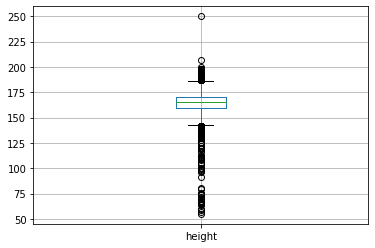

Нижняя граница выбросов для роста: 142.5 Верхняя граница выбросов для роста: 186.5


In [127]:
# определяет выбросы для роста по методу размаха квантилей
df_train.boxplot(column='height')
plt.show()
q1 = df_train['height'].quantile(0.25)
q3 = df_train['height'].quantile(0.75)
max_lim = q3 + 1.5 * (q3 - q1)
min_lim = q1 - 1.5 * (q3 - q1)
print("Нижняя граница выбросов для роста:", min_lim, "Верхняя граница выбросов для роста:", max_lim)

In [128]:
# получает кол-во объектов ниже нижней и выше верхней границ выбросов
print(len(df_train[df_train['height'] < min_lim]))
len(df_train[df_train['height'] > max_lim])

250


269

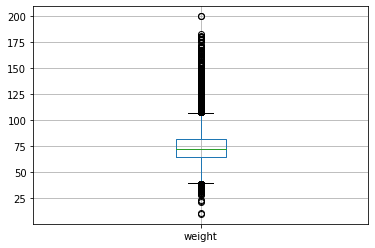

Нижняя граница выбросов для веса: 39.5 Верхняя граница выбросов для веса: 107.5


In [129]:
# определяет выбросы для веса по методу размаха квантилей
df_train.boxplot(column='weight')
plt.show()
q1 = df_train['weight'].quantile(0.25)
q3 = df_train['weight'].quantile(0.75)
max_lim = q3 + 1.5 * (q3 - q1)
min_lim = q1 - 1.5 * (q3 - q1)
print("Нижняя граница выбросов для веса:", min_lim, "Верхняя граница выбросов для веса:", max_lim)

In [130]:
# получает кол-во объектов ниже нижней и выше верхней границ выбросов
print(len(df_train[df_train['weight'] < min_lim]))
len(df_train[df_train['weight'] > max_lim])

52


1767

**Нижняя граница роста**

In [131]:
df_train.loc[df_train['height'] < 100]['height'].count()

29

In [132]:
df_train.loc[(df_train['height'] < 140) & (df_train['weight'] > df_train['height'])]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6153,8757,20990,0,122,161.0,120.0,80.0,0,0,0,0,1,1
7598,10843,14661,1,70,72.0,120.0,80.0,0,0,0,0,1,0
8171,11662,17646,1,97,170.0,160.0,100.0,0,0,1,0,1,1
12435,17757,22077,0,137,161.0,150.0,100.0,1,0,0,0,0,1
12770,18218,19594,0,75,168.0,120.0,80.0,0,0,1,0,1,1
15366,21958,17405,0,125,167.0,180.0,90.0,0,1,0,0,1,1
16699,23859,19680,1,74,98.0,140.0,90.0,0,0,0,0,1,1
20028,28605,19777,0,112,167.0,180.0,120.0,0,0,0,1,1,0
22723,32456,23386,0,55,81.0,130.0,90.0,0,0,0,0,1,1
23913,34186,19074,0,81,156.0,140.0,90.0,0,0,0,0,1,0


Рост ниже верхней границы и меньше веса признаём "заполнением наоброт" и меняем местами.\
При этом к весу меньше 100 прибавляем 100.\
Делает срез:

In [133]:
df_cut = df_train.loc[(df_train['height'] < 140) & (df_train['weight'] > df_train['height'])].copy()
df_cut.loc[df_cut['weight'] < 100, 'weight'] = df_cut.loc[df_cut['weight'] < 100, 'weight'] + 100

Меняет столбцы местами и проверяет:

In [134]:
df_cut.loc[:,['weight', 'height']] = df_cut.loc[:,['height', 'weight']].to_numpy()
df_cut

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6153,8757,20990,0,161.0,122.0,120.0,80.0,0,0,0,0,1,1
7598,10843,14661,1,172.0,70.0,120.0,80.0,0,0,0,0,1,0
8171,11662,17646,1,170.0,97.0,160.0,100.0,0,0,1,0,1,1
12435,17757,22077,0,161.0,137.0,150.0,100.0,1,0,0,0,0,1
12770,18218,19594,0,168.0,75.0,120.0,80.0,0,0,1,0,1,1
15366,21958,17405,0,167.0,125.0,180.0,90.0,0,1,0,0,1,1
16699,23859,19680,1,198.0,74.0,140.0,90.0,0,0,0,0,1,1
20028,28605,19777,0,167.0,112.0,180.0,120.0,0,0,0,1,1,0
22723,32456,23386,0,181.0,55.0,130.0,90.0,0,0,0,0,1,1
23913,34186,19074,0,156.0,81.0,140.0,90.0,0,0,0,0,1,0


Возвращает строки в основной ДФ:

In [135]:
df_train.loc[df_cut.index] = df_cut
df_train.loc[[66643]]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
66643,95141,18830,0,161.0,57.0,130.0,90.0,0,0,0,0,1,1


In [136]:
df_train.loc[df_train['height'] < 130]['height'].count()

74

In [137]:
df_train.loc[df_train['height'] < 100]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
224,309,21800,1,76.0,55.0,120.0,80.0,0,0,0,0,1,0
13265,18928,22456,1,71.0,68.0,120.0,80.0,2,0,0,0,1,0
14323,20459,22005,0,67.0,57.0,120.0,90.0,0,0,0,0,1,1
15167,21686,15812,0,70.0,68.0,120.0,80.0,0,0,0,0,0,0
17277,24690,17530,0,98.0,45.0,120.0,80.0,0,0,0,0,1,0
22542,32207,14538,0,68.0,65.0,100.0,60.0,0,0,0,0,0,0
27603,39462,20978,0,64.0,61.0,130.0,70.0,0,0,0,0,1,0
28737,41075,19747,0,91.0,55.0,140.0,90.0,0,0,0,0,1,1
44490,63545,19120,0,65.0,60.0,120.0,80.0,0,0,0,0,1,0
47352,67631,23297,0,75.0,75.0,120.0,80.0,0,0,0,0,1,0


In [138]:
bd_idx = df_train.loc[df_train['height'] < 100].tail().index
bd_idx

Int64Index([51459, 56022, 64115, 64454, 65302], dtype='int64')

In [139]:
df_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,20228,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,18857,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,17623,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,17474,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0


Значения ниже 130 меняет на медианные значения роста, сгруппированные по гендеру и весу.

Создаёт группу для веса:

In [140]:
df_train[['weight']].describe().T

,count,mean,std,min,25%,50%,75%,max
weight,70000.0,74.195619,14.360804,10.0,65.0,72.0,82.0,200.0


In [141]:
df_test[['weight']].describe().T

,count,mean,std,min,25%,50%,75%,max
weight,30000.0,74.120615,14.34154,10.0,65.0,72.0,82.0,183.0


In [142]:
bins_weight = [10,40,60,80,100,120,140,160,180,200]
df_train['weight_'] = pd.cut(df_train['weight'], bins_weight)

Проверим, как меняются медианные значения при группировке:

In [143]:
df_train.groupby(['gender', 'weight_'])[['height']].median()

height
gender weight_           
0      (10, 40]     152.0
       (40, 60]     158.0
       (60, 80]     163.0
       (80, 100]    162.0
       (100, 120]   163.0
       (120, 140]   163.0
       (140, 160]   163.0
       (160, 180]   168.0
       (180, 200]   173.5
1      (10, 40]     153.0
       (40, 60]     164.0
       (60, 80]     169.0
       (80, 100]    173.0
       (100, 120]   175.0
       (120, 140]   176.0
       (140, 160]   177.0
       (160, 180]   176.0
       (180, 200]   180.0

Группирует данные по категориям, подсчитывает для каждой группы медианное значение `heigh` и
 заполняет отсутсвующие данные в столбце `heigh`.

In [144]:
#проверяет работу "transform"
df_train.groupby(['gender', 'weight_'])['height'].transform('median')

0        169.0
1        162.0
2        163.0
3        173.0
4        158.0
         ...  
69995    169.0
69996    163.0
69997    175.0
69998    163.0
69999    163.0
Name: height, Length: 70000, dtype: float64

In [145]:
df_train.loc[df_train['height'] < 130, 'height'] = df_train.groupby(
    ['gender', 'weight_'])['height'].transform('median')

Проверяет результаты:

In [146]:
df_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_
0,0,18393,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0,"(60, 80]"
1,1,20228,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1,"(80, 100]"
2,2,18857,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1,"(60, 80]"
3,3,17623,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1,"(80, 100]"
4,4,17474,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0,"(40, 60]"


In [147]:
df_train.iloc[bd_idx]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_
51459,73386,15432,1,169.0,69.0,120.0,80.0,0,0,0,0,0,0,"(60, 80]"
56022,79917,21171,0,158.0,59.0,90.0,60.0,0,0,0,0,1,1,"(40, 60]"
64115,91523,18426,0,158.0,57.6,125.0,67.0,0,0,0,0,0,0,"(40, 60]"
64454,92008,21348,0,163.0,63.0,120.0,80.0,0,0,0,0,0,1,"(60, 80]"
65302,93223,18467,0,158.0,60.0,90.0,60.0,0,0,0,0,1,0,"(40, 60]"


In [148]:
df_train.loc[df_train['height'] < 130]['height'].count()

0

**Верхняя граница роста**

Верхней границей роста примем 200.

In [149]:
df_train.loc[df_train['height'] > 200]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_
6486,9223,21220,0,250.0,86.0,140.0,100.0,2,0,0,0,1,1,"(80, 100]"
21628,30894,19054,1,207.0,78.0,100.0,70.0,0,0,0,1,1,0,"(60, 80]"


То же самое: меняем на медианные значения, сгруппированные по гендеру и весу.

In [150]:
df_train.loc[df_train['height'] > 200, 'height'] = df_train.groupby(
    ['gender', 'weight_'])['height'].transform('median')

In [151]:
df_train.loc[df_train['height'] > 200]['id'].count()

0

**Тестовые данные**

<u>Нижняя граница роста</u>

In [152]:
df_test.loc[df_test['height'] < 100]['height'].count()

12

In [153]:
df_test.loc[(df_test['height'] < 140) & (df_test['weight'] > df_test['height'])]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
730,2495,21771,0,58,183.0,160.0,100.0,0,1,0,0,1
1114,3828,14653,1,65,74.0,120.0,40.0,1,0,1,0,1
15109,50367,22671,0,60,155.0,160.0,100.0,0,0,0,0,1
18312,61030,18899,1,87,173.0,140.0,80.0,0,0,0,0,1
18622,62052,20586,0,119,155.0,140.0,100.0,0,1,0,0,1
19504,65020,22855,0,52,78.0,120.0,80.0,0,0,0,0,1
24928,83304,21184,0,56,63.0,110.0,70.0,0,2,0,0,1
29020,96815,19846,0,52,60.0,110.0,70.0,0,0,0,0,1


Рост ниже верхней границы и меньше веса признаём "заполнением наоброт" и меняем столбцы местами.\
При этом к весу меньше 100 прибавляем 100.\
Делает срез:

In [154]:
df_cut = df_test.loc[(df_test['height'] < 140) & (df_test['weight'] > df_test['height'])].copy()
df_cut.loc[df_cut['weight'] < 100, 'weight'] = df_cut.loc[df_cut['weight'] < 100, 'weight'] + 100

Меняет столбцы местами и проверяет:

In [155]:
df_cut.loc[:,['weight', 'height']] = df_cut.loc[:,['height', 'weight']].to_numpy()
df_cut

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
730,2495,21771,0,183.0,58.0,160.0,100.0,0,1,0,0,1
1114,3828,14653,1,174.0,65.0,120.0,40.0,1,0,1,0,1
15109,50367,22671,0,155.0,60.0,160.0,100.0,0,0,0,0,1
18312,61030,18899,1,173.0,87.0,140.0,80.0,0,0,0,0,1
18622,62052,20586,0,155.0,119.0,140.0,100.0,0,1,0,0,1
19504,65020,22855,0,178.0,52.0,120.0,80.0,0,0,0,0,1
24928,83304,21184,0,163.0,56.0,110.0,70.0,0,2,0,0,1
29020,96815,19846,0,160.0,52.0,110.0,70.0,0,0,0,0,1


Возвращает строки в основной ДФ:

In [156]:
df_test.loc[df_cut.index] = df_cut
df_test.loc[[29020]]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
29020,96815,19846,0,160.0,52.0,110.0,70.0,0,0,0,0,1


Значения ниже 130 меняет на медианные значения роста, сгруппированные по гендеру и весу.

In [157]:
bins_weight = [10,40,60,80,100,120,140,160,180,200]
df_test['weight_'] = pd.cut(df_test['weight'], bins_weight)

Проверим, как меняются медианные значения при группировке:

In [158]:
df_test.groupby(['gender', 'weight_'])[['height']].median()

height
gender weight_           
0      (10, 40]     152.0
       (40, 60]     158.0
       (60, 80]     162.0
       (80, 100]    162.0
       (100, 120]   163.0
       (120, 140]   163.5
       (140, 160]   165.0
       (160, 180]   165.0
       (180, 200]     NaN
1      (10, 40]     168.0
       (40, 60]     164.0
       (60, 80]     169.0
       (80, 100]    172.0
       (100, 120]   175.0
       (120, 140]   177.0
       (140, 160]   176.0
       (160, 180]   165.0
       (180, 200]     NaN

In [159]:
# группирует данные по категориям, подсчитывает для каждой группы медианное значение 'heigh' и
# заполняет отсутсвующие данные в столбце 'heigh'
df_test.groupby(['gender', 'weight_'])['height'].transform('median')

0        162.0
1        169.0
2        162.0
3        172.0
4        169.0
         ...  
29995    175.0
29996    162.0
29997    169.0
29998    169.0
29999    169.0
Name: height, Length: 30000, dtype: float64

In [160]:
df_test.loc[df_test['height'] < 130, 'height'] = df_test.groupby(
    ['gender', 'weight_'])['height'].transform('median')

In [161]:
df_test.loc[df_train['height'] < 130]['height'].count()

0

<u>Верхняя граница роста</u>

Верхняя граница роста у нас 200.\
В тестовой выборке такие значения отсутствуют.

In [162]:
df_test.loc[df_test['height'] > 200]['id'].count()

0

### Вес `weight`

In [163]:
df_train[['weight']].describe().T

,count,mean,std,min,25%,50%,75%,max
weight,70000.0,74.195619,14.360804,10.0,65.0,72.0,82.0,200.0


In [164]:
df_test[['weight']].describe().T

,count,mean,std,min,25%,50%,75%,max
weight,30000.0,74.107548,14.305434,10.0,65.0,72.0,82.0,180.0


<u>Минимальные значения</u>

Здесь ориентируемся на значения выбросов: для веса нижнее значение 39.5.

In [165]:
df_train.loc[df_train['weight'] < 39]['weight'].count()

43

In [166]:
df_train.loc[df_train['weight'] < 39]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_
3752,5306,15400,0,152.0,30.00,110.0,70.0,0,0,0,0,1,0,"(10.0, 40.0]"
5794,8226,17663,0,151.0,37.00,120.0,80.0,0,0,0,0,1,0,"(10.0, 40.0]"
10447,14908,22007,0,162.0,38.00,100.0,70.0,0,0,0,0,1,0,"(10.0, 40.0]"
10627,15182,21669,0,153.0,37.00,150.0,80.0,2,2,0,0,1,1,"(10.0, 40.0]"
14722,21040,22663,0,143.0,34.00,100.0,70.0,0,0,0,0,1,0,"(10.0, 40.0]"
16322,23318,21872,0,165.0,35.00,100.0,70.0,0,0,0,0,1,0,"(10.0, 40.0]"
16906,24167,17272,1,170.0,31.00,150.0,90.0,1,1,0,0,1,1,"(10.0, 40.0]"
18559,26503,18140,0,160.0,30.00,120.0,80.0,0,0,0,0,1,1,"(10.0, 40.0]"
19582,27965,21334,0,152.0,38.00,110.0,80.0,0,0,0,0,1,0,"(10.0, 40.0]"
22016,31439,15359,0,146.0,32.00,100.0,70.0,0,0,0,0,0,0,"(10.0, 40.0]"


In [167]:
bd_idx = df_train.loc[df_train['weight'] < 39].tail().index
bd_idx

Int64Index([58200, 60188, 60699, 65082, 65650], dtype='int64')

Заменим значения ниже 39 медианными значениями, сгруппированными по росту и гендеру.\
(Вариант: по росту и верхнему давлению.)

Создаёт группу для роста:

In [168]:
df_train[['height']].describe().T

,count,mean,std,min,25%,50%,75%,max
height,70000.0,164.440229,7.854713,130.0,159.0,165.0,170.0,200.0


In [169]:
df_test[['height']].describe().T

,count,mean,std,min,25%,50%,75%,max
height,30000.0,164.400167,7.842127,130.0,159.0,165.0,170.0,198.0


In [170]:
bins_height = [130,150,160,170,180,190,200]
df_train['height_'] = pd.cut(df_train['height'], bins_height)

Проверим, как меняются медианные значения при группировке:

In [171]:
df_train.groupby(['gender', 'height_'])[['weight']].median()

weight
gender height_           
0      (130, 150]    65.0
       (150, 160]    69.0
       (160, 170]    71.0
       (170, 180]    75.0
       (180, 190]    81.0
       (190, 200]    80.0
1      (130, 150]    60.0
       (150, 160]    64.0
       (160, 170]    72.0
       (170, 180]    80.0
       (180, 190]    89.0
       (190, 200]    90.0

In [172]:
# проверяет работу 'transform'
df_train.groupby(['gender', 'height_'])['weight'].transform('median')

0        72.0
1        69.0
2        71.0
3        72.0
4        69.0
         ... 
69995    72.0
69996    69.0
69997    89.0
69998    71.0
69999    71.0
Name: weight, Length: 70000, dtype: float64

Группирует данные по категориям, подсчитывает для каждой группы медианное значение `heigh` и заполняет отсутсвующие данные в столбце `heigh`

In [173]:
df_train.loc[df_train['weight'] < 39, 'weight'] = df_train.groupby(
    ['gender', 'height_'])['weight'].transform('median')

In [174]:
df_train.loc[df_train['weight'] < 39]['weight'].count()

0

In [175]:
df_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_,height_
0,0,18393,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0,"(60, 80]","(160, 170]"
1,1,20228,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1,"(80, 100]","(150, 160]"
2,2,18857,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1,"(60, 80]","(160, 170]"
3,3,17623,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1,"(80, 100]","(160, 170]"
4,4,17474,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0,"(40, 60]","(150, 160]"


In [176]:
df_train.iloc[bd_idx]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_,height_
58200,83048,22544,0,169.0,71.0,140.0,90.0,1,0,0,0,1,1,"(10, 40]","(160, 170]"
60188,85931,21855,0,162.0,71.0,120.0,80.0,1,0,0,0,1,1,"(10, 40]","(160, 170]"
60699,86650,18875,0,171.0,75.0,110.0,70.0,1,0,0,0,1,1,"(10, 40]","(170, 180]"
65082,92896,22688,0,145.0,65.0,130.0,100.0,1,0,0,0,1,1,"(10, 40]","(130, 150]"
65650,93697,19114,0,147.0,65.0,100.0,70.0,2,2,0,0,1,0,"(10, 40]","(130, 150]"


<u>Максимальные значения</u>

In [177]:
df_train.loc[df_train['weight'] > 170]['weight'].count()

14

In [178]:
df_train.loc[df_train['weight'] > 170]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_,height_
435,618,16765,0,186.0,200.0,130.0,70.0,0,0,0,0,0,0,"(180, 200]","(180, 190]"
2441,3438,19171,1,177.0,177.0,130.0,90.0,0,0,0,0,1,1,"(160, 180]","(170, 180]"
4743,6716,17218,1,176.0,180.0,140.0,90.0,0,0,0,0,1,1,"(160, 180]","(170, 180]"
20092,28683,20656,1,165.0,178.0,120.0,80.0,0,0,1,1,1,0,"(160, 180]","(160, 170]"
36780,52564,19630,0,161.0,181.0,180.0,110.0,1,0,0,0,1,1,"(180, 200]","(160, 170]"
37590,53670,19909,0,162.0,175.0,140.0,100.0,0,0,0,0,1,1,"(160, 180]","(160, 170]"
45378,64829,17418,1,190.0,180.0,140.0,80.0,1,1,0,0,1,1,"(160, 180]","(180, 190]"
50413,71945,15117,1,180.0,200.0,150.0,90.0,0,0,0,0,1,1,"(180, 200]","(170, 180]"
56177,80152,15526,1,170.0,171.0,120.0,80.0,0,0,0,0,1,1,"(160, 180]","(160, 170]"
60592,86506,18975,1,180.0,180.0,140.0,100.0,2,0,0,0,1,1,"(160, 180]","(170, 180]"


In [179]:
df_train.loc[df_train['weight'] > 170, 'weight'] = df_train.groupby(
    ['gender', 'height_'])['weight'].transform('median')

In [180]:
df_train.loc[df_train['weight'] > 170]['weight'].count()

0

**Тестовые данные**

<u>Минимальные значения</u>

In [181]:
df_test.loc[df_test['weight'] < 39]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,weight_
259,854,15187,1,183.0,13.0,120.0,80.0,0,0,0,1,1,"(10.0, 40.0]"
2317,7812,19785,0,157.0,10.0,120.0,80.0,0,0,0,0,1,NaN
2905,9732,19687,0,130.0,30.0,120.0,80.0,0,0,0,0,1,"(10.0, 40.0]"
4413,14741,21301,0,159.0,38.0,100.0,80.0,0,0,0,0,1,"(10.0, 40.0]"
4721,15674,18377,0,147.0,34.0,100.0,60.0,0,0,0,0,1,"(10.0, 40.0]"
6148,20501,18380,0,144.0,35.0,120.0,80.0,0,0,0,0,0,"(10.0, 40.0]"
8005,26707,22645,0,162.0,38.0,110.0,80.0,1,1,0,0,1,"(10.0, 40.0]"
9315,31072,20670,0,165.0,32.0,120.0,80.0,2,2,0,0,0,"(10.0, 40.0]"
9339,31144,21845,0,147.0,37.0,110.0,70.0,2,2,0,0,1,"(10.0, 40.0]"
13830,46128,18808,0,151.0,37.0,120.0,80.0,2,0,0,0,1,"(10.0, 40.0]"


In [182]:
bins_height = [130,150,160,170,180,190,200]
df_test['height_'] = pd.cut(df_test['height'], bins_height)

Проверим, как меняются медианные значения при группировке:

In [183]:
df_test.groupby(['gender', 'height_'])[['weight']].median()

weight
gender height_           
0      (130, 150]    63.0
       (150, 160]    68.0
       (160, 170]    70.0
       (170, 180]    76.0
       (180, 190]    80.0
       (190, 200]    79.0
1      (130, 150]    57.5
       (150, 160]    64.0
       (160, 170]    72.0
       (170, 180]    80.0
       (180, 190]    89.0
       (190, 200]    88.0

In [184]:
df_test.groupby(['gender', 'height_'])['weight'].transform('median')

0        68.0
1        72.0
2        68.0
3        89.0
4        72.0
         ... 
29995    72.0
29996    76.0
29997    72.0
29998    80.0
29999    80.0
Name: weight, Length: 30000, dtype: float64

In [185]:
df_test.loc[df_test['weight'] < 39, 'weight'] = df_test.groupby(
    ['gender', 'height_'])['weight'].transform('median')

In [186]:
df_test.loc[df_test['weight'] < 39]['weight'].count()

0

<u>Максимальные значения</u>

In [187]:
df_test.loc[df_test['weight'] > 170]['weight'].count()

5

In [188]:
df_test.loc[df_test['weight'] > 170]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,weight_,height_
7879,26298,17511,0,165.0,180.0,90.0,60.0,0,0,0,0,1,"(160, 180]","(160, 170]"
13261,44218,17612,0,170.0,171.0,140.0,90.0,1,0,0,1,0,"(160, 180]","(160, 170]"
18696,62296,20339,0,165.0,178.0,120.0,80.0,0,0,0,0,1,"(160, 180]","(160, 170]"
22895,76557,20543,0,173.0,175.0,140.0,90.0,0,0,0,0,1,"(160, 180]","(170, 180]"
23624,79008,20556,0,165.0,178.0,120.0,80.0,0,0,0,0,1,"(160, 180]","(160, 170]"


In [189]:
df_test.loc[df_test['weight'] > 170, 'weight'] = df_test.groupby(
    ['gender', 'height_'])['weight'].transform('median')

In [190]:
df_test.loc[df_test['weight'] > 170]['weight'].count()

0

### Давление `ap_lo` + `ap_hi`

#### `ap_lo` > `ap_hi`

Исправляем ситуации, когда "нижнее" давление больше "верхнего":

**Тренировочные данные**

In [191]:
df_train.loc[(df_train['ap_lo'] > df_train['ap_hi'])]['id'].count()

111

In [192]:
df_train.loc[(df_train['ap_lo'] > df_train['ap_hi'])].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_,height_
474,681,19099,0,156.0,65.0,120.0,150.0,1,0,0,0,1,0,"(60, 80]","(150, 160]"
636,913,20457,1,169.0,68.0,70.0,110.0,0,0,0,0,1,0,"(60, 80]","(160, 170]"
2384,3356,23361,0,154.0,102.0,90.0,150.0,0,0,0,0,0,1,"(100, 120]","(150, 160]"
2990,4214,21957,1,182.0,90.0,80.0,140.0,2,2,0,0,1,1,"(80, 100]","(180, 190]"
3447,4880,19992,1,180.0,80.0,80.0,125.0,2,2,1,1,1,1,"(60, 80]","(170, 180]"


In [193]:
bd_idx = df_train.loc[(df_train['ap_lo'] > df_train['ap_hi'])].head().index
bd_idx

Int64Index([474, 636, 2384, 2990, 3447], dtype='int64')

Меняет столбцы местами:

In [194]:
df_train.loc[(df_train['ap_lo'] > df_train['ap_hi']), ['ap_lo', 'ap_hi']] =\
    df_train.loc[(df_train['ap_lo'] > df_train['ap_hi']), ['ap_hi', 'ap_lo']].to_numpy()

Проверяет:

In [195]:
df_train.loc[bd_idx]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_,height_
474,681,19099,0,156.0,65.0,150.0,120.0,1,0,0,0,1,0,"(60, 80]","(150, 160]"
636,913,20457,1,169.0,68.0,110.0,70.0,0,0,0,0,1,0,"(60, 80]","(160, 170]"
2384,3356,23361,0,154.0,102.0,150.0,90.0,0,0,0,0,0,1,"(100, 120]","(150, 160]"
2990,4214,21957,1,182.0,90.0,140.0,80.0,2,2,0,0,1,1,"(80, 100]","(180, 190]"
3447,4880,19992,1,180.0,80.0,125.0,80.0,2,2,1,1,1,1,"(60, 80]","(170, 180]"


In [196]:
df_train.loc[(df_train['ap_lo'] > df_train['ap_hi'])]['id'].count()

0

**Тестовые данные**

In [197]:
df_test.loc[(df_test['ap_lo'] > df_test['ap_hi'])]['id'].count()

50

Меняет столбцы местами:

In [198]:
df_test.loc[(df_test['ap_lo'] > df_test['ap_hi']), ['ap_lo', 'ap_hi']] =\
    df_test.loc[(df_test['ap_lo'] > df_test['ap_hi']), ['ap_hi', 'ap_lo']].to_numpy()

Проверяет:

In [199]:
df_test.loc[(df_test['ap_lo'] > df_test['ap_hi'])]['id'].count()

0

In [200]:
df_train[['ap_lo']].describe().T

,count,mean,std,min,25%,50%,75%,max
ap_lo,70000.0,81.564827,9.829502,0.0,80.0,80.0,90.0,182.0


#### Нулевые значения 'ap_lo'

In [201]:
df_train.loc[df_train['ap_lo'] == 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_,height_
13489,19258,14965,1,150.0,60.0,130.0,0.0,0,0,0,0,0,0,"(40, 60]","(130, 150]"
25454,36325,17952,1,176.0,73.0,120.0,0.0,0,0,0,0,1,0,"(60, 80]","(170, 180]"
27686,39577,23396,1,180.0,73.0,140.0,0.0,0,0,1,1,1,1,"(60, 80]","(170, 180]"
45835,65470,19597,1,165.0,70.0,140.0,0.0,2,0,1,0,1,0,"(60, 80]","(160, 170]"
52580,75007,21919,0,155.0,66.0,130.0,0.0,0,0,0,0,1,0,"(60, 80]","(150, 160]"
56950,81298,15268,0,164.0,70.0,120.0,0.0,0,0,0,0,1,0,"(60, 80]","(160, 170]"
65303,93224,23612,1,176.0,99.0,120.0,0.0,0,2,0,0,1,1,"(80, 100]","(170, 180]"


In [202]:
bd_idx = df_train.loc[df_train['ap_lo'] == 0].index
bd_idx

Int64Index([13489, 25454, 27686, 45835, 52580, 56950, 65303], dtype='int64')

Чем заполняем нулевые значения `ap_lo`?\
Медианными значениями разницы между "верхним" и "нижним" давлением `ap_hi-ap_lo`, сгруппированными по весу и возрасту.

Добавляем промежуточный (т.к. некоторые данные у нас пока отсутствуют) столбец разницы верхнего и нижнего давлений `ap_diff_`:

In [203]:
df_train['ap_diff_'] = df_train['ap_hi'] - df_train['ap_lo']
df_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_,height_,ap_diff_
0,0,18393,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0,"(60, 80]","(160, 170]",30.0
1,1,20228,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1,"(80, 100]","(150, 160]",50.0
2,2,18857,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1,"(60, 80]","(160, 170]",60.0
3,3,17623,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1,"(80, 100]","(160, 170]",50.0
4,4,17474,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0,"(40, 60]","(150, 160]",40.0


Создаём категории для возраста:

In [204]:
age = df_train[['age']]/365.25
age.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,53.30285,6.754967,29.563313,48.361396,53.943874,58.390144,64.922656


In [205]:
bins_age = [29, 35, 40, 45, 50, 55, 60, 65]
for i in range(len(bins_age)):    
    bins_age[i] = bins_age[i]*365.25
bins_age

[10592.25, 12783.75, 14610.0, 16436.25, 18262.5, 20088.75, 21915.0, 23741.25]

In [206]:
df_train['age_'] = pd.cut(df_train['age'], bins_age)

In [207]:
df_train.groupby(['weight_', 'age_'])[['ap_diff_']].median()

ap_diff_
weight_    age_                          
(10, 40]   (10592.25, 12783.75]       NaN
           (12783.75, 14610.0]       30.0
           (14610.0, 16436.25]       40.0
           (16436.25, 18262.5]       40.0
           (18262.5, 20088.75]       42.5
...                                   ...
(180, 200] (14610.0, 16436.25]       60.0
           (16436.25, 18262.5]       60.0
           (18262.5, 20088.75]       70.0
           (20088.75, 21915.0]       30.0
           (21915.0, 23741.25]        NaN

[63 rows x 1 columns]

In [208]:
df_train.loc[df_train['ap_lo'] == 0, 'ap_lo'] =\
    df_train.loc[df_train['ap_lo'] == 0, 'ap_hi'] - df_train.groupby(
    ['weight_', 'age_'])['ap_diff_'].transform('median')

In [209]:
df_train.loc[df_train['ap_lo'] == 0]['id'].count()

0

In [210]:
df_train.loc[bd_idx]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,weight_,height_,ap_diff_,age_
13489,19258,14965,1,150.0,60.0,130.0,90.0,0,0,0,0,0,0,"(40, 60]","(130, 150]",130.0,"(14610.0, 16436.25]"
25454,36325,17952,1,176.0,73.0,120.0,80.0,0,0,0,0,1,0,"(60, 80]","(170, 180]",120.0,"(16436.25, 18262.5]"
27686,39577,23396,1,180.0,73.0,140.0,100.0,0,0,1,1,1,1,"(60, 80]","(170, 180]",140.0,"(21915.0, 23741.25]"
45835,65470,19597,1,165.0,70.0,140.0,100.0,2,0,1,0,1,0,"(60, 80]","(160, 170]",140.0,"(18262.5, 20088.75]"
52580,75007,21919,0,155.0,66.0,130.0,90.0,0,0,0,0,1,0,"(60, 80]","(150, 160]",130.0,"(21915.0, 23741.25]"
56950,81298,15268,0,164.0,70.0,120.0,80.0,0,0,0,0,1,0,"(60, 80]","(160, 170]",120.0,"(14610.0, 16436.25]"
65303,93224,23612,1,176.0,99.0,120.0,70.0,0,2,0,0,1,1,"(80, 100]","(170, 180]",120.0,"(21915.0, 23741.25]"


Удалим столбец с  промежуточными данными:

In [211]:
df_train.drop(columns='ap_diff_', inplace=True)

**Тестовые данные**

In [212]:
age = df_test[['age']]/365.25
age.describe().T

,count,mean,std,min,25%,50%,75%,max
age,30000.0,53.266334,6.783959,24.271047,48.344969,53.919233,58.370979,64.900753


Добавляем промежуточный столбец разницы верхнего и нижнего давлений `ap_diff_`:

In [213]:
df_test['ap_diff_'] = df_test['ap_hi'] - df_test['ap_lo']
df_test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,weight_,height_,ap_diff_
0,5,18888,0,154.0,85.0,130.0,80.0,0,0,0,0,1,"(80, 100]","(150, 160]",50.0
1,6,19042,1,170.0,69.0,130.0,90.0,0,0,0,0,1,"(60, 80]","(160, 170]",40.0
2,7,20432,0,160.0,70.0,120.0,75.0,0,0,0,0,0,"(60, 80]","(150, 160]",45.0
3,10,18133,1,185.0,94.0,130.0,90.0,0,0,0,0,1,"(80, 100]","(180, 190]",40.0
4,11,16093,1,170.0,76.0,120.0,80.0,0,0,0,0,1,"(60, 80]","(160, 170]",40.0


In [214]:
df_test.loc[df_test['ap_lo'] == 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,weight_,height_,ap_diff_
7906,26367,20577,0,169.0,78.0,120.0,0.0,1,0,0,0,1,"(60, 80]","(160, 170]",120.0
12852,42755,19136,0,158.0,61.0,130.0,0.0,0,0,0,0,1,"(60, 80]","(150, 160]",130.0
13138,43735,23324,1,184.0,88.0,100.0,0.0,2,0,0,0,0,"(80, 100]","(180, 190]",100.0
15437,51515,20361,0,165.0,66.0,108.0,0.0,0,0,0,0,1,"(60, 80]","(160, 170]",108.0
24538,81975,20579,0,164.0,59.0,108.0,0.0,0,0,0,0,1,"(40, 60]","(160, 170]",108.0
29327,97796,21863,1,160.0,59.0,118.0,0.0,0,0,0,0,1,"(40, 60]","(150, 160]",118.0


In [215]:
bd_idx = df_test.loc[df_test['ap_lo'] == 0].index
bd_idx

Int64Index([7906, 12852, 13138, 15437, 24538, 29327], dtype='int64')

In [216]:
df_test['age_'] = pd.cut(df_test['age'], bins_age)

In [217]:
df_test.groupby(['weight_', 'age_'])[['ap_diff_']].median()

ap_diff_
weight_    age_                          
(10, 40]   (10592.25, 12783.75]       NaN
           (12783.75, 14610.0]       20.0
           (14610.0, 16436.25]       40.0
           (16436.25, 18262.5]       40.0
           (18262.5, 20088.75]       40.0
...                                   ...
(180, 200] (14610.0, 16436.25]        NaN
           (16436.25, 18262.5]        NaN
           (18262.5, 20088.75]        NaN
           (20088.75, 21915.0]        NaN
           (21915.0, 23741.25]        NaN

[63 rows x 1 columns]

In [218]:
df_test.loc[df_test['ap_lo'] == 0, 'ap_lo'] =\
    df_test.loc[df_test['ap_lo'] == 0, 'ap_hi'] - df_test.groupby(
    ['weight_', 'age_'])['ap_diff_'].transform('median')

In [219]:
df_test.loc[df_test['ap_lo'] == 0]['id'].count()

0

In [220]:
df_test.loc[bd_idx]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,weight_,height_,ap_diff_,age_
7906,26367,20577,0,169.0,78.0,120.0,80.0,1,0,0,0,1,"(60, 80]","(160, 170]",120.0,"(20088.75, 21915.0]"
12852,42755,19136,0,158.0,61.0,130.0,90.0,0,0,0,0,1,"(60, 80]","(150, 160]",130.0,"(18262.5, 20088.75]"
13138,43735,23324,1,184.0,88.0,100.0,50.0,2,0,0,0,0,"(80, 100]","(180, 190]",100.0,"(21915.0, 23741.25]"
15437,51515,20361,0,165.0,66.0,108.0,68.0,0,0,0,0,1,"(60, 80]","(160, 170]",108.0,"(20088.75, 21915.0]"
24538,81975,20579,0,164.0,59.0,108.0,68.0,0,0,0,0,1,"(40, 60]","(160, 170]",108.0,"(20088.75, 21915.0]"
29327,97796,21863,1,160.0,59.0,118.0,78.0,0,0,0,0,1,"(40, 60]","(150, 160]",118.0,"(20088.75, 21915.0]"


Удалим столбец с  промежуточными данными:

In [221]:
df_test.drop(columns='ap_diff_', inplace=True)

Проверяет пропуски в данных, т.к. при группировке в финальной группе тестовой выборки было много NaN'ов:

In [222]:
df_train.isna().sum()

id              0
age             0
gender          0
height          0
weight          0
ap_hi           0
ap_lo           0
cholesterol     0
gluc            0
smoke           0
alco            0
active          0
cardio          0
weight_         1
height_        12
age_            0
dtype: int64

In [223]:
df_test.isna().sum()

id             0
age            0
gender         0
height         0
weight         1
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
weight_        2
height_        8
age_           3
dtype: int64

In [224]:
df_test.loc[df_test['weight'].isna()]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,weight_,height_,age_
2905,9732,19687,0,130.0,NaN,120.0,80.0,0,0,0,0,1,"(10, 40]",NaN,"(18262.5, 20088.75]"


In [225]:
df_test.loc[df_test['id'] == 9732 , 'weight'] = 63

Проверяет значения давления:

In [226]:
df_train[['ap_hi']].describe().T

,count,mean,std,min,25%,50%,75%,max
ap_hi,70000.0,127.068567,17.054691,60.0,120.0,120.0,140.0,240.0


In [227]:
df_test[['ap_hi']].describe().T

,count,mean,std,min,25%,50%,75%,max
ap_hi,30000.0,127.097286,16.955945,76.0,120.0,120.0,140.0,240.0


### Восстанавливает типы данных

In [228]:
df_train.dtypes

id                int64
age               int64
gender            int64
height          float64
weight          float64
ap_hi           float64
ap_lo           float64
cholesterol       int64
gluc              int64
smoke             int64
alco              int64
active            int64
cardio            int64
weight_        category
height_        category
age_           category
dtype: object

In [229]:
df_train['height'] = df_train['height'].astype(int)
df_train['weight'] = df_train['weight'].astype(int)
df_train['ap_hi'] = df_train['ap_hi'].astype(int)
df_train['ap_lo'] = df_train['ap_lo'].astype(int)

In [230]:
df_test.dtypes

id                int64
age               int64
gender            int64
height          float64
weight          float64
ap_hi           float64
ap_lo           float64
cholesterol       int64
gluc              int64
smoke             int64
alco              int64
active            int64
weight_        category
height_        category
age_           category
dtype: object

In [231]:
df_test['height'] = df_test['height'].astype(int)
df_test['weight'] = df_test['weight'].astype(int)
df_test['ap_hi'] = df_test['ap_hi'].astype(int)
df_test['ap_lo'] = df_test['ap_lo'].astype(int)

Удалим столбцы-посредники, т.к. они больше не нужны:

In [232]:
df_train = df_train.drop(
    ['weight_','height_','age_'], axis=1)
df_test = df_test.drop(
    ['weight_','height_','age_'], axis=1)

In [233]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           70000 non-null  int64
 1   age          70000 non-null  int64
 2   gender       70000 non-null  int64
 3   height       70000 non-null  int32
 4   weight       70000 non-null  int32
 5   ap_hi        70000 non-null  int32
 6   ap_lo        70000 non-null  int32
 7   cholesterol  70000 non-null  int64
 8   gluc         70000 non-null  int64
 9   smoke        70000 non-null  int64
 10  alco         70000 non-null  int64
 11  active       70000 non-null  int64
 12  cardio       70000 non-null  int64
dtypes: int32(4), int64(9)
memory usage: 5.9 MB


In [234]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           30000 non-null  int64
 1   age          30000 non-null  int64
 2   gender       30000 non-null  int64
 3   height       30000 non-null  int32
 4   weight       30000 non-null  int32
 5   ap_hi        30000 non-null  int32
 6   ap_lo        30000 non-null  int32
 7   cholesterol  30000 non-null  int64
 8   gluc         30000 non-null  int64
 9   smoke        30000 non-null  int64
 10  alco         30000 non-null  int64
 11  active       30000 non-null  int64
dtypes: int32(4), int64(8)
memory usage: 2.3 MB


<u>Выводы</u>:
проведена предобработка данных - выявлены и устранены аномальные значения в параметрах.\
При обработке сделаны следующие ограничения:\
1) `ap_hi` ("верхнее" давление) - нижний порог ограничен значением 60, верхний не ограничен;\
2) `ap_lo` ("нижнее" давление) - нижний порог ограничен значением 20, верхний не ограничен;\
3) `height` (рост) - минимальный - 130, максимальный - 205\
4) `weight` (вес) - минимальный - 39, максимальный - 170.\

Данные, выходящие за указанные границы, были заменены медианными значениями, сгрупированными по параметрам, максимально коррелирующим с заменяемыми данными. 

# 3. Исследовательский анализ данных

Снова получает описание данных:

In [235]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,0.349571,0.476838,0.0,0.00,0.0,1.00,1.0
height,70000.0,164.440229,7.854713,130.0,159.00,165.0,170.00,200.0
weight,70000.0,74.195371,14.244399,39.0,65.00,72.0,82.00,170.0
ap_hi,70000.0,127.068471,17.054786,60.0,120.00,120.0,140.00,240.0
ap_lo,70000.0,81.573186,9.795978,20.0,80.00,80.0,90.00,182.0
cholesterol,70000.0,0.366871,0.680250,0.0,0.00,0.0,1.00,2.0
gluc,70000.0,0.226457,0.572270,0.0,0.00,0.0,0.00,2.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [236]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,50062.686900,28906.167148,5.0,24983.25,49995.5,75232.25,99997.0
age,30000.0,19455.528400,2477.840922,8865.0,17658.00,19694.0,21320.00,23705.0
gender,30000.0,0.353733,0.478136,0.0,0.00,0.0,1.00,1.0
height,30000.0,164.400167,7.842127,130.0,159.00,165.0,170.00,198.0
weight,30000.0,74.118100,14.191504,39.0,65.00,72.0,82.00,170.0
ap_hi,30000.0,127.097067,16.956073,76.0,120.00,120.0,140.00,240.0
ap_lo,30000.0,81.614800,9.712722,20.0,80.00,80.0,90.00,172.0
cholesterol,30000.0,0.368033,0.679166,0.0,0.00,0.0,1.00,2.0
gluc,30000.0,0.222700,0.566494,0.0,0.00,0.0,0.00,2.0
smoke,30000.0,0.088600,0.284170,0.0,0.00,0.0,0.00,1.0


Исследуем взаимосвязи данных:

In [237]:
df_train.drop(['id'], axis=1).corr(method='spearman')\
    .sort_values(by='cardio', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
cardio,0.234429,0.008109,-0.012372,0.182682,0.456929,0.363822,0.215117,0.091488,-0.015486,-0.007330,-0.035653,1.000000
ap_hi,0.221152,0.064247,0.019512,0.280613,1.000000,0.749464,0.209877,0.106919,0.028615,0.035984,-0.001597,0.456929
ap_lo,0.157387,0.066022,0.029969,0.255148,0.749464,1.000000,0.168464,0.081908,0.025751,0.037329,0.003537,0.363822
age,1.000000,-0.020176,-0.082789,0.062004,0.221152,0.157387,0.140113,0.091791,-0.047471,-0.030078,-0.010422,0.234429
cholesterol,0.140113,-0.035730,-0.059568,0.138031,0.209877,0.168464,1.000000,0.407803,0.015220,0.041285,0.007573,0.215117
weight,0.062004,0.172232,0.314255,1.000000,0.280613,0.255148,0.138031,0.110159,0.071549,0.068102,-0.014760,0.182682
gluc,0.091791,-0.018866,-0.024614,0.110159,0.106919,0.081908,0.407803,1.000000,0.000468,0.018584,-0.008610,0.091488
gender,-0.020176,1.000000,0.535515,0.172232,0.064247,0.066022,-0.035730,-0.018866,0.338135,0.170966,0.005866,0.008109
alco,-0.030078,0.170966,0.096621,0.068102,0.035984,0.037329,0.041285,0.018584,0.340094,1.000000,0.025476,-0.007330
height,-0.082789,0.535515,1.000000,0.314255,0.019512,0.029969,-0.059568,-0.024614,0.197903,0.096621,-0.007934,-0.012372


Построим матрицу корреляции:

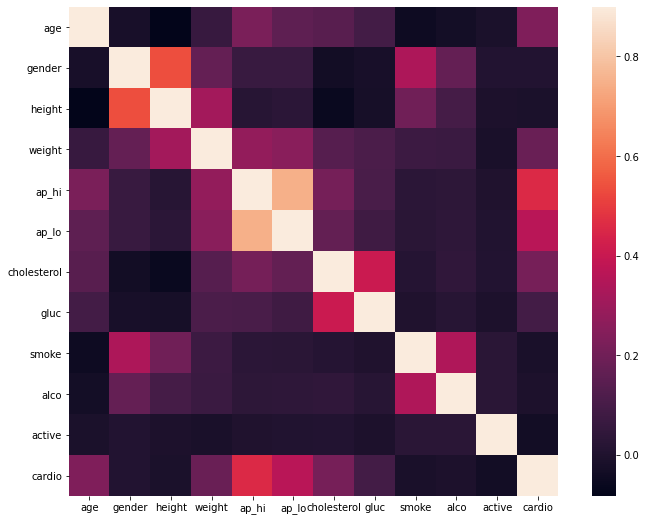

In [238]:
corrmat = df_train.drop(['id'], axis=1).corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True)
plt.show()

Обработанные данные показывают всё ту же корреляцию:

- наибольшая корреляция ЦП - с `ap_hi`, затем `ap_lo`, возраст (`age`), вес, холестерол, глюкоза.
- наибольшая корреляция `ap_hi` - с `ap_lo`, затем - `weight` (вес) 
- наибольшая корреляция веса - с ростом (`height`), что логично
- курение, алкоголь, активность, пол и даже рост - не коррелируют с ЦП, во всяком случае, не коррелируют с ним НАПРЯМУЮ.

# 4. Разработка модели ML

### Удаление лишних данных

In [239]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           70000 non-null  int64
 1   age          70000 non-null  int64
 2   gender       70000 non-null  int64
 3   height       70000 non-null  int32
 4   weight       70000 non-null  int32
 5   ap_hi        70000 non-null  int32
 6   ap_lo        70000 non-null  int32
 7   cholesterol  70000 non-null  int64
 8   gluc         70000 non-null  int64
 9   smoke        70000 non-null  int64
 10  alco         70000 non-null  int64
 11  active       70000 non-null  int64
 12  cardio       70000 non-null  int64
dtypes: int32(4), int64(9)
memory usage: 5.9 MB


При построении модели следующие данные нам не потребуются и окажутся лишними -- они не содержат никакой полезной информации для модели:<br>
- `id` - номер записи\
- столбцы-посредники: `weight_`, `height_`, `age_`

Готовим выборку:\
извлекаем признаки и целевой признак:

In [240]:
X_train = df_train.drop(['cardio'], axis=1)
y_train = df_train['cardio']

Проверяем:

In [241]:
print(X_train.shape, y_train.shape)
df_test.shape

(70000, 12) (70000,)


(30000, 12)

Удаляем лишние признаки:

In [242]:
X_train = X_train.drop(
    ['id'], axis=1)
X_test = df_test.drop(
    ['id'], axis=1)

In [243]:
# X_train = X_train.drop(
#     ['id','weight_','height_','age_'], axis=1)
# X_test = df_test.drop(
#     ['id','weight_','height_','age_'], axis=1)

In [244]:
print(X_train.shape, y_train.shape)
X_test.shape

(70000, 11) (70000,)


(30000, 11)

Проверяет дисбаланс классов:

In [245]:
# обучающая выборка
y_train.value_counts(normalize=True)

0    0.5003
1    0.4997
Name: cardio, dtype: float64

Дисбаланс отсутствует.

### Построение и выбор модели

В качестве метрики для обучения моделей будем использовать параметр `F1-мера` с контролем по `AUC-ROC`.

In [246]:
X_train_lr = X_train.copy()
y_upsampled = y_train.copy()

In [247]:
#категориальные признаки
ohe_features = X_train_lr.select_dtypes(include='object').columns.to_list()
print(ohe_features)

[]


In [248]:
#численные признаки
num_features = X_train_lr.select_dtypes(exclude='object').columns.to_list()

# удаляет из списка категориальные бинарные признаки
num_features.remove('gender')
num_features.remove('smoke')
num_features.remove('alco')
num_features.remove('active')

print(num_features)

['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']


#### Логистическая регрессия

In [249]:
col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), 
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    #verbose_feature_names_out=False
)

model_lr = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs')


pipline_lr = make_pipeline(col_transformer_lr, model_lr)

param_lr = {
    'logisticregression__max_iter': range(100, 1001, 100),
    'logisticregression__C': (0.1, 1.5, 0.1)    
}

# использует GridSearchCV
gs_lr = GridSearchCV(
    pipline_lr, 
    param_grid=param_lr,
    scoring={'AUC':'roc_auc', 'F1':'f1'},
    refit='AUC',
    n_jobs=-1
)

gs_lr.fit(X_train_lr, y_upsampled)

gs_lr_best_AUC = gs_lr.best_score_
gs_lr_best_F1 = gs_lr.cv_results_["mean_test_F1"].max()
gs_lr_best_params = gs_lr.best_params_
print(f'best_score F1-мера: {gs_lr_best_F1}')
print(f'best_score AUC-ROC: {gs_lr_best_AUC}')
print(f'best_params: {gs_lr_best_params}')

best_score F1-мера: 0.7132422906336128
best_score AUC-ROC: 0.7932193083672162
best_params: {'logisticregression__C': 1.5, 'logisticregression__max_iter': 100}


#### Решающее дерево

In [250]:
X_train_dt = X_train.copy()
# X_test_dt = X_test.copy()

In [251]:
col_transformer_dt = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), 
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    #verbose_feature_names_out=False
)

model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)


pipline_dt = make_pipeline(col_transformer_dt, model_dt)

param_dt = {
    'decisiontreeclassifier__max_depth': range(2, 15),
    'decisiontreeclassifier__min_samples_split': (2, 3, 4),
    'decisiontreeclassifier__min_samples_leaf': (1, 2, 3, 4)
}

# использует RandomizedSearchCV
rs_dt = RandomizedSearchCV(
    pipline_dt, 
    param_distributions=param_dt, 
    scoring={'AUC':'roc_auc', 'F1':'f1'},
    refit='AUC',
    # n_iter=20,
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

rs_dt.fit(X_train_dt, y_upsampled)

rs_dt_best_AUC = rs_dt.best_score_
rs_dt_best_F1 = rs_dt.cv_results_["mean_test_F1"].max()
rs_dt_best_params = rs_dt.best_params_
print(f'best_score F1-мера: {rs_dt_best_F1}')
print(f'best_score AUC-ROC: {rs_dt_best_AUC}')
print(f'best_params: {rs_dt_best_params}')

best_score F1-мера: 0.7285149192498386
best_score AUC-ROC: 0.7950988845976968
best_params: {'decisiontreeclassifier__min_samples_split': 4, 'decisiontreeclassifier__min_samples_leaf': 3, 'decisiontreeclassifier__max_depth': 6}


#### Случайный лес

In [252]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [253]:
col_transformer_rf = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), 
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    #verbose_feature_names_out=False
)

model_rf = RandomForestClassifier(random_state=RANDOM_STATE)


pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_rf = {
    'randomforestclassifier__n_estimators': range(70, 301, 10),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}

# использует RandomizedSearchCV
rs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_rf, 
    scoring={'AUC':'roc_auc','F1':'f1'},
    refit='AUC',
    # n_iter=20,
    n_jobs=-1,    
    random_state=RANDOM_STATE
)

rs_rf.fit(X_train_rf, y_upsampled)

rs_rf_best_AUC = rs_rf.best_score_
rs_rf_best_F1 = rs_rf.cv_results_["mean_test_F1"].max()
rs_rf_best_params = rs_rf.best_params_
print(f'best_score F1-мера: {rs_rf_best_F1}')
print(f'best_score AUC-ROC: {rs_rf_best_AUC}')
print(f'best_params: {rs_rf_best_params}')

best_score F1-мера: 0.7240546487382716
best_score AUC-ROC: 0.802648622034971
best_params: {'randomforestclassifier__n_estimators': 280, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 13}


Сравним результаты моделей:

In [254]:
result = pd.DataFrame(
    {'F1':[gs_lr_best_F1, rs_dt_best_F1, rs_rf_best_F1],
    'AUC-ROC':[gs_lr_best_AUC, rs_dt_best_AUC, rs_rf_best_AUC]}, 
    index=['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier']
)
result

,F1,AUC-ROC
LogisticRegression,0.713242,0.793219
DecisionTreeClassifier,0.728515,0.795099
RandomForestClassifier,0.724055,0.802649


<u>Выводы</u>:\
Наилучший результат показала модель Случайного леса с параметрами:\
*randomforestclassifier__n_estimators': 280, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 13.*\
У остальных моделей результаты лишь немного отличаются от лучшего.\
Возможно, это связано с особенностью данных.

# 5. Инжиниринг данных

Здесь есть две идеи:

1 - добавить параметр разницы между верхним и нижним давлением.\
Можно попробовать заменить параметр нижнего давления этой разницей.

2 - рассчитать т.н. "индекс массы тела": соотношение роста и веса.

### Разница между верхним и нижним давлением

In [255]:
df_train['ap_diff'] = df_train['ap_hi'] - df_train['ap_lo']
df_test['ap_diff'] = df_test['ap_hi'] - df_test['ap_lo']

In [256]:
df_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff
0,0,18393,1,168,62,110,80,0,0,0,0,1,0,30
1,1,20228,0,156,85,140,90,2,0,0,0,1,1,50
2,2,18857,0,165,64,130,70,2,0,0,0,0,1,60
3,3,17623,1,169,82,150,100,0,0,0,0,1,1,50
4,4,17474,0,156,56,100,60,0,0,0,0,0,0,40


### Индекс массы тела (индекс Кетле)

Формула расчёта: массу тела в килограммах разделить на рост в метрах в квадрате.

In [257]:
df_train['bmi'] = (df_train['weight'] / ((df_train['height']/100)**2)).round(2)
df_test['bmi'] = (df_test['weight'] / ((df_test['height']/100)**2)).round(2)

In [258]:
df_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff,bmi
0,0,18393,1,168,62,110,80,0,0,0,0,1,0,30,21.97
1,1,20228,0,156,85,140,90,2,0,0,0,1,1,50,34.93
2,2,18857,0,165,64,130,70,2,0,0,0,0,1,60,23.51
3,3,17623,1,169,82,150,100,0,0,0,0,1,1,50,28.71
4,4,17474,0,156,56,100,60,0,0,0,0,0,0,40,23.01


In [259]:
df_train.drop(['id'], axis=1).corr(method='spearman')\
    .sort_values(by='cardio', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff,bmi
cardio,0.234429,0.008109,-0.012372,0.182682,0.456929,0.363822,0.215117,0.091488,-0.015486,-0.007330,-0.035653,1.000000,0.359204,0.199069
ap_hi,0.221152,0.064247,0.019512,0.280613,1.000000,0.749464,0.209877,0.106919,0.028615,0.035984,-0.001597,0.456929,0.800828,0.284475
ap_lo,0.157387,0.066022,0.029969,0.255148,0.749464,1.000000,0.168464,0.081908,0.025751,0.037329,0.003537,0.363822,0.279810,0.252079
ap_diff,0.181072,0.036578,-0.000618,0.190250,0.800828,0.279810,0.164918,0.087295,0.020507,0.022374,0.000148,0.359204,1.000000,0.200225
age,1.000000,-0.020176,-0.082789,0.062004,0.221152,0.157387,0.140113,0.091791,-0.047471,-0.030078,-0.010422,0.234429,0.181072,0.108893
cholesterol,0.140113,-0.035730,-0.059568,0.138031,0.209877,0.168464,1.000000,0.407803,0.015220,0.041285,0.007573,0.215117,0.164918,0.174783
bmi,0.108893,-0.089395,-0.181738,0.849012,0.284475,0.252079,0.174783,0.128768,-0.024575,0.022820,-0.009332,0.199069,0.200225,1.000000
weight,0.062004,0.172232,0.314255,1.000000,0.280613,0.255148,0.138031,0.110159,0.071549,0.068102,-0.014760,0.182682,0.190250,0.849012
gluc,0.091791,-0.018866,-0.024614,0.110159,0.106919,0.081908,0.407803,1.000000,0.000468,0.018584,-0.008610,0.091488,0.087295,0.128768
gender,-0.020176,1.000000,0.535515,0.172232,0.064247,0.066022,-0.035730,-0.018866,0.338135,0.170966,0.005866,0.008109,0.036578,-0.089395


Видим, что ни один из этих новых параметров не приблизился по корреляции с ЦП к параметру верхнего давления.

Подготовим данные и проверим их на модели, позказавшей лучший результат на предыдущих данных.

In [260]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int32  
 4   weight       70000 non-null  int32  
 5   ap_hi        70000 non-null  int32  
 6   ap_lo        70000 non-null  int32  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
 13  ap_diff      70000 non-null  int32  
 14  bmi          70000 non-null  float64
dtypes: float64(1), int32(5), int64(9)
memory usage: 6.7 MB


При построении модели следующие данные нам не потребуются и окажутся лишними -- они не содержат никакой полезной информации для модели:<br>
- `id` - номер записи\
- столбцы-посредники: `weight_`, `height_`, `age_`

Готовим выборку:\
извлекаем признаки и целевой признак:

In [261]:
X_train = df_train.drop(['cardio'], axis=1)
y_train = df_train['cardio']

Проверяем:

In [262]:
print(X_train.shape, y_train.shape)
df_test.shape

(70000, 14) (70000,)


(30000, 14)

Удаляем лишние признаки: должно получиться по ___ столбцов в каждом X ДФ:

In [263]:
X_train = X_train.drop(
    ['id'], axis=1)
X_test = df_test.drop(
    ['id'], axis=1)

In [264]:
# X_train = X_train.drop(
#     ['id','weight_','height_','age_'], axis=1)
# X_test = df_test.drop(
#     ['id','weight_','height_','age_'], axis=1)

In [265]:
print(X_train.shape, y_train.shape)
X_test.shape

(70000, 13) (70000,)


(30000, 13)

In [266]:
X_train_lr = X_train.copy()
y_upsampled = y_train.copy()

In [267]:
#категориальные признаки
ohe_features = X_train_lr.select_dtypes(include='object').columns.to_list()
print(ohe_features)

[]


In [268]:
#численные признаки
num_features = X_train_lr.select_dtypes(exclude='object').columns.to_list()

# удаляет из списка категориальные бинарные признаки
num_features.remove('gender')
num_features.remove('smoke')
num_features.remove('alco')
num_features.remove('active')

print(num_features)

['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'ap_diff', 'bmi']


### Новый Случайный лес

In [269]:
X_train_rf_new = X_train.copy()
X_test_rf_new = X_test.copy()

In [270]:
col_transformer_rf_new = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), 
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    #verbose_feature_names_out=False
)

model_rf_new = RandomForestClassifier(random_state=RANDOM_STATE)


pipline_rf_new = make_pipeline(col_transformer_rf_new, model_rf_new)

param_rf_new = {
    'randomforestclassifier__n_estimators': range(70, 301, 10),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}

# использует RandomizedSearchCV
rs_rf_new = RandomizedSearchCV(
    pipline_rf_new, 
    param_distributions=param_rf_new, 
    scoring={'AUC':'roc_auc','F1':'f1'},
    refit='AUC',
    # n_iter=20,
    n_jobs=-1,    
    random_state=RANDOM_STATE
)

rs_rf_new.fit(X_train_rf_new, y_upsampled)

rs_rf_best_AUC = rs_rf_new.best_score_
rs_rf_best_F1 = rs_rf_new.cv_results_["mean_test_F1"].max()
rs_rf_best_params = rs_rf_new.best_params_
print(f'best_score F1-мера: {rs_rf_best_F1}')
print(f'best_score AUC-ROC: {rs_rf_best_AUC}')
print(f'best_params: {rs_rf_best_params}')

best_score F1-мера: 0.7237658288393487
best_score AUC-ROC: 0.8024612954400441
best_params: {'randomforestclassifier__n_estimators': 280, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 13}


<u>Вывод</u>:\
Результат даже слекга ухудшился по сравнению с предыдущим.\
Получается, наш инжиниринг данных дал лишь ухудшение результата. Отказываемся.

# 6. Прогноз

Используя обученную модель с наилучшими параметрами, получим необходимые данные прогноза.

In [271]:
predictied_test = rs_rf.predict(X_test_rf)
probabilities_test = rs_rf.predict_proba(X_test_rf)
probabilities_one_test = probabilities_test[:, 1]

In [272]:
probabilities_test

array([[0.49567854, 0.50432146],
       [0.4437666 , 0.5562334 ],
       [0.59888494, 0.40111506],
       ...,
       [0.52357708, 0.47642292],
       [0.64005283, 0.35994717],
       [0.29026985, 0.70973015]])

In [273]:
probabilities_one_test

array([0.50432146, 0.5562334 , 0.40111506, ..., 0.47642292, 0.35994717,
       0.70973015])

In [274]:
proba = df_test['id'].copy()
proba

0            5
1            6
2            7
3           10
4           11
         ...  
29995    99984
29996    99987
29997    99989
29998    99994
29999    99997
Name: id, Length: 30000, dtype: int64

In [275]:
#proba['cardio'] = probabilities_one_test

In [276]:
proba = pd.DataFrame(proba)
proba

,id
0,5
1,6
2,7
3,10
4,11
...,...
29995,99984
29996,99987
29997,99989
29998,99994


In [277]:
one_test = pd.DataFrame(probabilities_one_test)
one_test

,0
0,0.504321
1,0.556233
2,0.401115
3,0.521638
4,0.224586
...,...
29995,0.840637
29996,0.231959
29997,0.476423
29998,0.359947


In [278]:
proba['cardio'] = one_test[0]

In [279]:
proba

,id,cardio
0,5,0.504321
1,6,0.556233
2,7,0.401115
3,10,0.521638
4,11,0.224586
...,...,...
29995,99984,0.840637
29996,99987,0.231959
29997,99989,0.476423
29998,99994,0.359947


In [280]:
# формат записи для выгрузки результатов на Kaggle (см. также файл 'sample_submission.csv'):
# proba.to_csv('result.csv', sep=',', header=True, decimal='.', index=False)